# Data Sources

Get data 

## import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()



Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://docs.openbb.co/sdk/quickstart/installation/

## definitions

In [2]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))
ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2023-01-01 00:00:00"
LAST_DATE =  "2023-06-27 00:00:00"
TIMEFRAME = "5m"
PATH_DATA = "data"
path_save_df_eth = "data/df_eth_05m.csv"
path_save_df_eth_2 = "data/df_eth_2_05m.csv"
path_save_df_btc = "data/df_btc_05m.csv"
path_save_df_btc_2 = "data/df_btc_2_05m.csv"
path_save_df_bnb = "data/df_bnb_05m.csv"
path_save_df_bnb_2 = "data/df_bnb_2_05m.csv"
path_save_df_eco = "data/df_eco.csv"
path_save_df_feat = "data/df_feat_05m.csv"

# CCXT crypto exchanges declaration
exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

kucoin = ccxt.kucoin({
    'rateLimit': 1,
    'enableRateLimit': True,
})


## Download data

In [3]:
ohlcvs = exchange.fetch_ohlcv(ETH_TICK, TIMEFRAME)
ohlcvs

[[1687674900000, 1927.23, 1929.19, 1924.01, 1924.04, 2483.4011],
 [1687675200000, 1924.04, 1925.9, 1919.64, 1921.57, 2012.3721],
 [1687675500000, 1921.56, 1923.88, 1917.42, 1921.55, 2071.3166],
 [1687675800000, 1921.54, 1922.84, 1920.04, 1920.61, 1135.4616],
 [1687676100000, 1920.61, 1922.03, 1920.06, 1920.07, 781.401],
 [1687676400000, 1920.07, 1920.79, 1917.0, 1917.02, 1454.7013],
 [1687676700000, 1917.01, 1919.29, 1917.01, 1918.52, 822.8398],
 [1687677000000, 1918.51, 1919.67, 1917.94, 1919.58, 496.5088],
 [1687677300000, 1919.58, 1919.59, 1915.94, 1916.15, 1411.802],
 [1687677600000, 1916.14, 1916.15, 1908.24, 1909.99, 3403.8015],
 [1687677900000, 1909.99, 1912.88, 1909.99, 1912.53, 1117.6869],
 [1687678200000, 1912.54, 1912.79, 1907.48, 1910.01, 1780.3116],
 [1687678500000, 1910.0, 1910.6, 1909.63, 1910.47, 661.3766],
 [1687678800000, 1910.48, 1911.82, 1910.47, 1911.82, 648.056],
 [1687679100000, 1911.82, 1911.91, 1908.62, 1910.69, 796.4127],
 [1687679400000, 1910.69, 1911.8, 1909

In [4]:
ohlcvs[0][0]

1687674900000

In [5]:
ohlcvs[-1][0]

1687824600000

In [6]:
ohlcvs[-1][0] - ohlcvs[0][0]

149700000

In [7]:
len(ohlcvs)

500

In [8]:
(ohlcvs[-1][0] - ohlcvs[0][0]) / (len(ohlcvs)-1)

300000.0

In [9]:
300000.0 / (60*1000)

5.0

In [10]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE

# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp, params= { 'until': to_timestamp})
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            timeframe_ms = int((last - first) / (len(ohlcvs)-1))
            from_timestamp += len(ohlcvs) * timeframe_ms
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms') # -> date object
    df['date'] = df['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except AssertionError as error:
        print(error)
        return False




    
def req_ohlcv_all(exchange, first_date=FIRST_DATE, last_date=LAST_DATE):

    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        first_date,  
        last_date,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    return df_eth, df_btc, df_bnb

def merge_ohlcv_data(df_old, df_new):

    # Merge old with new data 
    df = pd.concat([df_old, df_new], ignore_index=True)
    print("df_old.shape: ", df_old.shape)
    print("df_new.shape: ", df_new.shape)
    print("Before : df.shape: ", df.shape)
    df = df.drop_duplicates(
        subset=["date"], keep="last", ignore_index=True)
    print("After : df.shape: ", df.shape)
    return df



def get_ohlcv_all(exchange, path_save_df_eth, path_save_df_btc, path_save_df_bnb):
    """
    Get prices from disk and from exchange if update needed
    """
    # reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)
    
    return df_eth, df_btc, df_bnb

In [11]:
data_ok = check_data()
print(data_ok)

if not data_ok:
    
    df_eth, df_btc, df_bnb = req_ohlcv_all(exchange)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:

    df_eth, df_btc, df_bnb = get_ohlcv_all(
        exchange,
        path_save_df_eth,
        path_save_df_btc,
        path_save_df_bnb
    )
    '''# reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)'''
        

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

True
Reload data binance exchange from disk...
New data to download...
1687824774556 Fetching candles starting from 2023-06-07T23:45:00.000Z


1687824775352 Fetched 500 candles
First candle epoch 1686181500000 2023-06-07T23:45:00.000Z
Last candle epoch 1686331200000 2023-06-09T17:20:00.000Z
1687824775352 Fetching candles starting from 2023-06-09T17:25:00.000Z
1687824776343 Fetched 500 candles
First candle epoch 1686331500000 2023-06-09T17:25:00.000Z
Last candle epoch 1686481200000 2023-06-11T11:00:00.000Z
1687824776343 Fetching candles starting from 2023-06-11T11:05:00.000Z
1687824777210 Fetched 500 candles
First candle epoch 1686481500000 2023-06-11T11:05:00.000Z
Last candle epoch 1686631200000 2023-06-13T04:40:00.000Z
1687824777211 Fetching candles starting from 2023-06-13T04:45:00.000Z
1687824778255 Fetched 500 candles
First candle epoch 1686631500000 2023-06-13T04:45:00.000Z
Last candle epoch 1686781200000 2023-06-14T22:20:00.000Z
1687824778255 Fetching candles starting from 2023-06-14T22:25:00.000Z
1687824779220 Fetched 500 candles
First candle epoch 1686781500000 2023-06-14T22:25:00.000Z
Last candle epoch 1686931200000 

In [12]:
pd.read_csv(path_save_df_eth)

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
50955,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00
50956,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00
50957,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00
50958,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00


In [13]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
50955,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00
50956,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00
50957,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00
50958,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00


In [14]:
test_time_continuity(df_eth)

Time gap!


False

In [15]:

data_ok_2 = check_data_2()

if not data_ok_2:

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    print("Reload data kucoin exchange from disk...")

    df_eth_2, df_btc_2, df_bnb_2 = get_ohlcv_all(
        exchange,
        path_save_df_eth_2,
        path_save_df_btc_2,
        path_save_df_bnb_2,
    )
    '''# reload from disk
    
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False) 
    '''

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



Reload data kucoin exchange from disk...
Reload data binance exchange from disk...
New data to download...
1687824808096 Fetching candles starting from 2023-06-07T23:45:00.000Z


1687824808399 Fetched 500 candles
First candle epoch 1686181500000 2023-06-07T23:45:00.000Z
Last candle epoch 1686331200000 2023-06-09T17:20:00.000Z
1687824808399 Fetching candles starting from 2023-06-09T17:25:00.000Z
1687824809585 Fetched 500 candles
First candle epoch 1686331500000 2023-06-09T17:25:00.000Z
Last candle epoch 1686481200000 2023-06-11T11:00:00.000Z
1687824809585 Fetching candles starting from 2023-06-11T11:05:00.000Z
1687824810499 Fetched 500 candles
First candle epoch 1686481500000 2023-06-11T11:05:00.000Z
Last candle epoch 1686631200000 2023-06-13T04:40:00.000Z
1687824810499 Fetching candles starting from 2023-06-13T04:45:00.000Z
1687824811669 Fetched 500 candles
First candle epoch 1686631500000 2023-06-13T04:45:00.000Z
Last candle epoch 1686781200000 2023-06-14T22:20:00.000Z
1687824811679 Fetching candles starting from 2023-06-14T22:25:00.000Z
1687824812515 Fetched 500 candles
First candle epoch 1686781500000 2023-06-14T22:25:00.000Z
Last candle epoch 1686931200000 

In [16]:
df_eth_2

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.21,1196.22,1195.53,1196.14,64.898071,2023-01-01 00:00:00
1,1672531500000,1196.22,1196.51,1195.06,1195.30,65.407549,2023-01-01 00:05:00
2,1672531800000,1195.30,1195.65,1194.56,1194.56,53.841561,2023-01-01 00:10:00
3,1672532100000,1194.41,1195.98,1194.31,1195.88,31.516025,2023-01-01 00:15:00
4,1672532400000,1195.87,1196.41,1195.87,1195.98,13.723162,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.960100,2023-06-26 23:40:00
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.478000,2023-06-26 23:45:00
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.042100,2023-06-26 23:50:00
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.782900,2023-06-26 23:55:00


In [17]:
df_eth

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
50955,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00
50956,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00
50957,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00
50958,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00


In [18]:
assert df_eth["Time"].values[0] == df_eth_2["Time"].values[0], "Time reference (first) must be the same!"

In [19]:
def get_unique(df_):
    d_time = np.diff(df_["Time"].values)
    #np.max(d_time) == np.min(d_time)
    unique_val, unique_inv, unique_counts = np.unique(d_time, return_inverse=True, return_counts=True)
    print(unique_val)
    print(unique_counts)
    print(unique_inv)
    return unique_val, unique_counts, unique_inv

In [20]:
a,b,c = get_unique(df_eth)

[ 300000  600000 5100000]
[50957     1     1]
[0 0 0 ... 0 0 0]


In [21]:
c==4

array([False, False, False, ..., False, False, False])

In [22]:
#df_eth.Time[c==4]

In [23]:
d_time = np.diff(df_eth["Time"].values)
#np.max(d_time) == np.min(d_time)
unique_val, unique_counts = np.unique(d_time, return_counts=True)
print(unique_val)
print(unique_counts)

[ 300000  600000 5100000]
[50957     1     1]


In [24]:
d_time = np.diff(df_eth_2["Time"].values)
#np.max(d_time) == np.min(d_time)
unique_val, unique_index, unique_counts = np.unique(d_time, return_index=True, return_counts=True)
print(unique_val)
print(unique_counts)
unique_index

[300000]
[50976]


array([0])

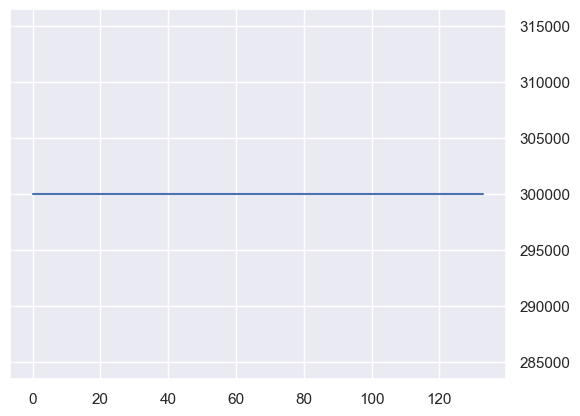

In [25]:
plt.plot(np.diff(df_eth["Time"].values[-135:]))

In [26]:
df_eth["date"].iloc[-135:].head(10)

50825    2023-06-26 12:50:00
50826    2023-06-26 12:55:00
50827    2023-06-26 13:00:00
50828    2023-06-26 13:05:00
50829    2023-06-26 13:10:00
50830    2023-06-26 13:15:00
50831    2023-06-26 13:20:00
50832    2023-06-26 13:25:00
50833    2023-06-26 13:30:00
50834    2023-06-26 13:35:00
Name: date, dtype: object

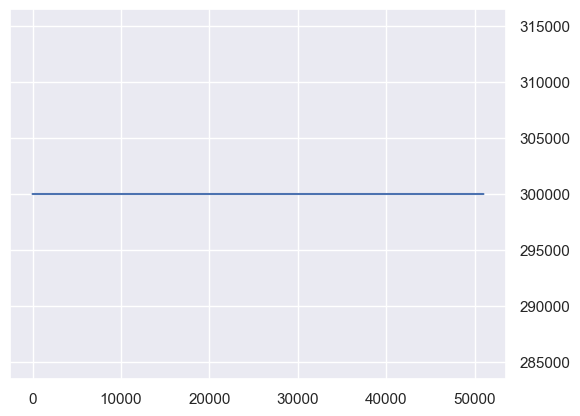

In [27]:
plt.plot(np.diff(df_eth_2["Time"].values))

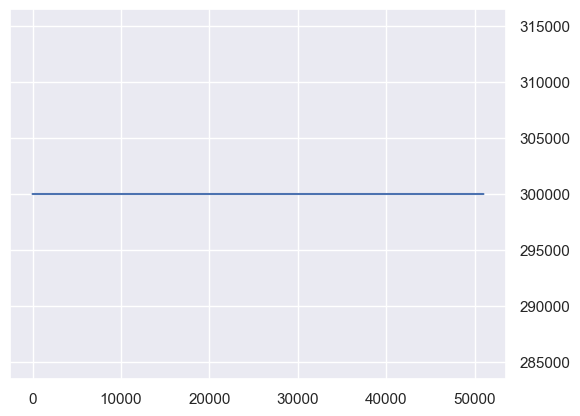

In [28]:
plt.plot(np.diff(df_eth_2["Time"].values))

In [29]:
test_time_continuity(df_eth)

Time gap!


False

In [30]:
test_time_continuity(df_eth_2)

True

In [31]:
def add_nb_time(df_in):
    """
    modify index to be the n-th time-step from first time.
    so a gap in time is reflected into index.
    add nb_time columns (maybe useless).
    """
    df = df_in.copy()
    delta_min = df["Time"].diff().value_counts().index[0]
    df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
    df.index = df["nb_time"].values

    list_index = (
        list(set(list(range(df["nb_time"].values[-1]))) 
             - set(list(df["nb_time"].values)))
    )


    return df, list_index

In [32]:
def fill_time_gap(df_in, df_2):
    """
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin)
    So we use all prices of kucoin for missing dates
    Also, we add estimate unkonwn binance volumes in proportion of previous 
    "hour" known volumes from the two exchanges.

    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df

In [33]:
def fill_time_gap_interp(df_in, df_2):
    """
    Imputation of ohlcv CCTX nan data : 
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin) 
        So we use all prices of kucoin for missing dates
        Also, we add estimate unkonwn binance volumes in proportion of previous 
        "hour" known volumes from the two exchanges.

    If kucoin have also time gap ! OMG!
        So we use all prices of kucoin for missing dates
        If also Nan for kucoin, we interpolate (linear) binance data with Binance data only
        Nan & Zero volumes are interpolate also (unlike former fill_time_gap...) with Binance data only
    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            #raise Exception("Error good input data 2")

            # two exchanges have nan values !!! OMG!!!
            # use interpolate
            df, l_index = add_nb_time(df)
            df_2, l_index_2 = add_nb_time(df_2)
            new_index = np.array(range(max(df["nb_time"])+1))
            df = df.reindex(new_index)
            df_2 = df_2.reindex(new_index)
            df_mix = df.join(df_2, rsuffix='_2')
            b_nan = df_mix["Open"].isna()
            df_mix.loc[b_nan, "Open"] = df_mix.loc[b_nan, "Open_2"]
            df_mix.loc[b_nan, "High"] = df_mix.loc[b_nan, "High_2"]
            df_mix.loc[b_nan, "Low"] = df_mix.loc[b_nan, "Low_2"]
            df_mix.loc[b_nan, "Close"] = df_mix.loc[b_nan, "Close_2"]
            df_mix.loc[b_nan, "Time"] = df_mix.loc[b_nan, "Time_2"]
            df_mix.loc[b_nan, "date"] = df_mix.loc[b_nan, "date_2"]
            df_mix.loc[b_nan, "nb_time"] = df_mix.loc[b_nan, "nb_time_2"]

            # special volume zero :
            df_mix.loc[df_mix["Volume"] <= 0, "Volume"] = np.nan

            # interpolate 
            df_mix["Open"] = df_mix["Open"].interpolate()
            df_mix["High"] = df_mix["High"].interpolate()
            df_mix["Low"] = df_mix["Low"].interpolate()
            df_mix["Close"] = df_mix["Close"].interpolate()
            df_mix["Volume"] = df_mix["Volume"].interpolate()
            df_mix["Time"] = df_mix["Time"].interpolate()
            df_mix["nb_time"] = df_mix["nb_time"].interpolate()

            # Date
            df_mix['date'] = pd.to_datetime(df_mix['Time'], unit='ms') # -> date object
            df_mix['date'] = df_mix['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

            # keep good col only
            # Time	Open	High	Low	Close	Volume	date	nb_time
            df_mix = df_mix[["Time",	"Open",	"High",	"Low",	
                            "Close",	"Volume",	"date",	"nb_time"]]
            
            if not test_time_continuity(df_mix):
                raise Exception("Error no good interpolated data")
            return df_mix

    else:
        return df

In [34]:
#df_eth = fill_time_gap(df_eth, df_eth_2)
#df_btc = fill_time_gap(df_btc, df_btc_2)
#df_bnb = fill_time_gap(df_bnb, df_bnb_2)

df_eth = fill_time_gap_interp(df_eth, df_eth_2)
df_btc = fill_time_gap_interp(df_btc, df_btc_2)
df_bnb = fill_time_gap_interp(df_bnb, df_bnb_2)

Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume index 23774
Correcting volume index 23775
Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume in

In [35]:
test_time_continuity(df_eth) and test_time_continuity(df_btc) and test_time_continuity(df_bnb) 

True

In [36]:
df_btc

,Time,Open,High,Low,Close,Volume,date
0,1672531200000,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00
1,1672531500000,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00
2,1672531800000,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00
3,1672532100000,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00
4,1672532400000,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00
...,...,...,...,...,...,...,...
50972,1687822800000,30244.64,30244.64,30228.00,30239.27,25.68563,2023-06-26 23:40:00
50973,1687823100000,30239.28,30286.63,30239.27,30285.80,88.63094,2023-06-26 23:45:00
50974,1687823400000,30285.80,30286.63,30273.75,30273.76,45.33353,2023-06-26 23:50:00
50975,1687823700000,30273.76,30273.76,30264.98,30267.99,30.55664,2023-06-26 23:55:00


Text(0.0, 1.0, 'Volume BTC binance')

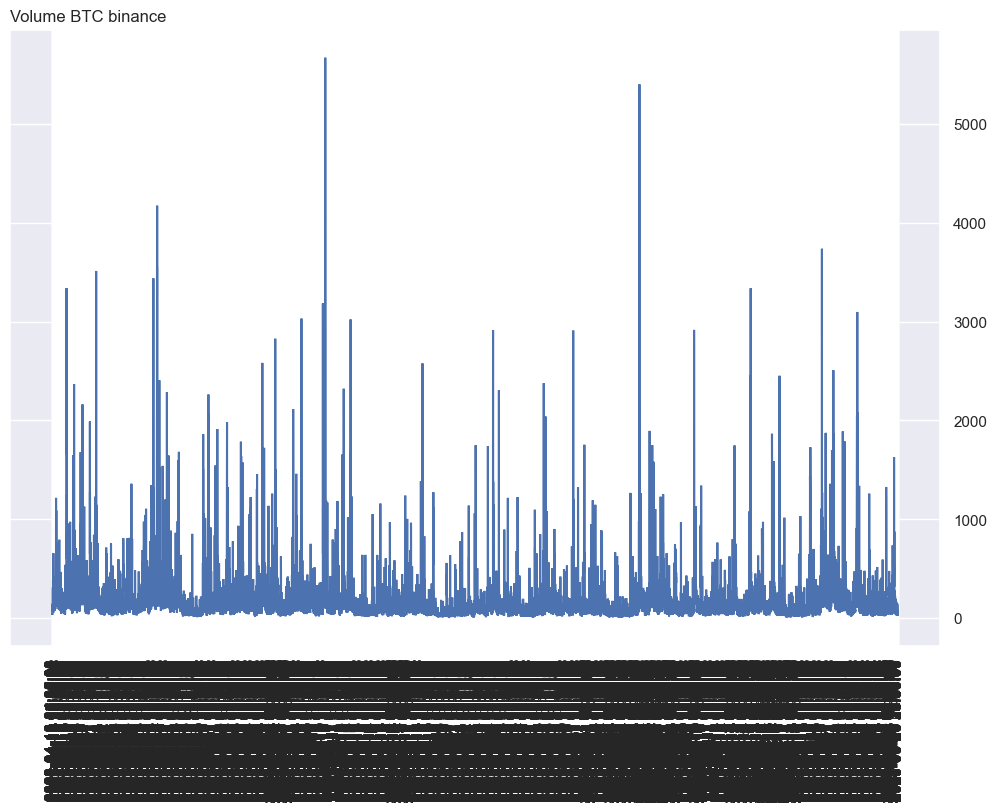

In [37]:
b_last = df_btc["date"] > "2023-04-18 04:00:00"
fig = plt.figure(figsize=(12, 8))
plt.plot(df_btc[b_last]["date"], df_btc[b_last]["Volume"])
plt.xticks(rotation=90)
plt.title("Volume BTC binance")

## Merge everything

In [38]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)


In [39]:
# df_feat 
df_feat = df_eth.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

df_feat.shape

(50977, 19)

In [40]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,Open_BTC,High_BTC,Low_BTC,Close_BTC,Volume_BTC,date_BTC,Open_BNB,High_BNB,Low_BNB,Close_BNB,Volume_BNB,date_BNB
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,246.3,246.4,245.9,246.2,440.108,2023-01-01 00:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,246.2,246.2,246.0,246.1,96.972,2023-01-01 00:05:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,246.1,246.1,246.0,246.0,242.254,2023-01-01 00:10:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,246.0,246.2,245.8,246.2,369.308,2023-01-01 00:15:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,246.2,246.5,246.1,246.4,149.299,2023-01-01 00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,30244.64,30244.64,30228.00,30239.27,25.68563,2023-06-26 23:40:00,236.0,236.0,235.6,235.9,415.256,2023-06-26 23:40:00
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,30239.28,30286.63,30239.27,30285.80,88.63094,2023-06-26 23:45:00,235.9,236.2,235.9,236.0,1228.467,2023-06-26 23:45:00
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,30285.80,30286.63,30273.75,30273.76,45.33353,2023-06-26 23:50:00,236.1,236.2,236.0,236.1,341.183,2023-06-26 23:50:00
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,30273.76,30273.76,30264.98,30267.99,30.55664,2023-06-26 23:55:00,236.1,236.1,236.0,236.1,87.116,2023-06-26 23:55:00


## Save

In [41]:
path_save_df_feat

'data/df_feat_05m.csv'

In [42]:
df_feat.to_csv(path_save_df_feat, index=False)

## Add price action indicators

Ichimoku 1h 1D 1W

In [43]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_day = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24,
        window2=26*24,
        window3=52*24,
    )
    df_out["ichi_cloud_a_day"] = indic_ichi_day.ichimoku_a()
    df_out["ichi_cloud_b_day"] = indic_ichi_day.ichimoku_b()
    df_out["ichi_kijun_day"] = indic_ichi_day.ichimoku_base_line()
    df_out["ichi_tenkan_day"] = indic_ichi_day.ichimoku_conversion_line()

    indic_ichi_week = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*24*7,
        window2=26*24*7,
        window3=52*24*7,
    )
    df_out["ichi_cloud_a_week"] = indic_ichi_week.ichimoku_a()
    df_out["ichi_cloud_a_week"].ffill(inplace=True)
    df_out["ichi_cloud_b_week"] = indic_ichi_week.ichimoku_b()
    df_out["ichi_kijun_week"] = indic_ichi_week.ichimoku_base_line()
    df_out["ichi_tenkan_week"] = indic_ichi_week.ichimoku_conversion_line()
    
    return df_out

df_eth = add_ichimoku(df_eth)
df_btc = add_ichimoku(df_btc)

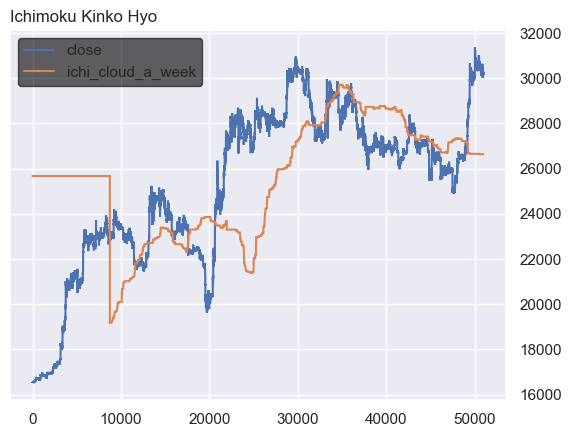

In [44]:
plt.plot(df_btc.Close, label="close")
plt.plot(df_btc["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

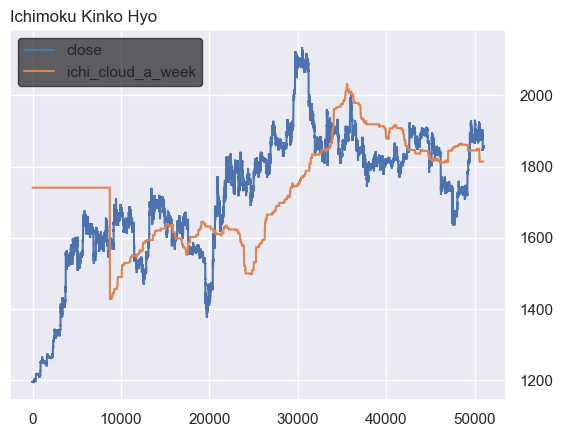

In [45]:
plt.plot(df_eth.Close, label="close")
plt.plot(df_eth["ichi_cloud_a_week"], label='ichi_cloud_a_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

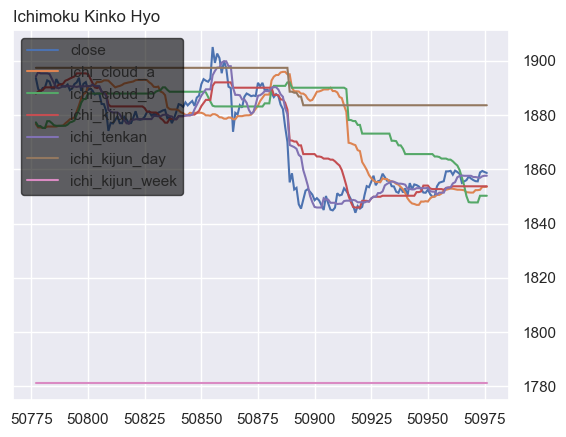

In [46]:
plt.plot(df_eth[-200:].Close, label="close")
plt.plot(df_eth[-200:]["ichi_cloud_a"], label='ichi_cloud_a')
plt.plot(df_eth[-200:]["ichi_cloud_b"], label='ichi_cloud_b')
plt.plot(df_eth[-200:]["ichi_kijun"], label='ichi_kijun')
plt.plot(df_eth[-200:]["ichi_tenkan"], label='ichi_tenkan')
plt.plot(df_eth[-200:]["ichi_kijun_day"], label='ichi_kijun_day')
plt.plot(df_eth[-200:]["ichi_kijun_week"], label='ichi_kijun_week')
plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

RSI 14  1h 1D 1W

In [47]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df, n=14):
    df_out = df.copy()
    df_out["rsi_h"] = RSIIndicator(df["High"], window=n).rsi()
    df_out["rsi_d"] = RSIIndicator(df["High"], window=n*24).rsi()
    df_out["rsi_w"] = RSIIndicator(df["High"], window=n*24*7).rsi()
    return df_out


df_eth = add_rsi(df_eth)
df_btc = add_rsi(df_btc)
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_cloud_b_day,ichi_kijun_day,ichi_tenkan_day,ichi_cloud_a_week,ichi_cloud_b_week,ichi_kijun_week,ichi_tenkan_week,rsi_h,rsi_d,rsi_w
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,1709.991759,NaN,NaN,1740.787217,1670.622795,NaN,NaN,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,1709.991759,NaN,NaN,1740.787217,1670.622795,NaN,NaN,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,1709.991759,NaN,NaN,1740.787217,1670.622795,NaN,NaN,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,1709.991759,NaN,NaN,1740.787217,1670.622795,NaN,NaN,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,1709.991759,NaN,NaN,1740.787217,1670.622795,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,1825.570000,1883.59,1873.14,1813.992500,1821.325000,1781.215,1886.8,45.558136,47.251558,50.494041
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,1825.570000,1883.59,1873.14,1813.992500,1821.325000,1781.215,1886.8,57.884062,47.601936,50.544835
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,1825.570000,1883.59,1873.14,1813.992500,1821.325000,1781.215,1886.8,61.435590,47.733459,50.564001
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,1825.570000,1883.59,1873.14,1813.992500,1821.325000,1781.215,1886.8,58.434283,47.665589,50.552916


Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [48]:
# add CHOP indicator on 1hour 1day 1week 
def add_chop(df, n):
    df_out = df.copy()

    def calculate_chop(df, n, k):
        #(high: pandas.core.series.Series, 
        # low: pandas.core.series.Series, 
        # close: pandas.core.series.Series, 
        # window: int = 14, 
        # fillna: bool = False)
        atr = AverageTrueRange(
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            window=1*k,
            ).average_true_range()
        sum_atr = atr.rolling(n*k).sum()
        max_high = df_out["High"].rolling(n*k).max()
        min_low = df_out["Low"].rolling(n*k).min()
        chop = 100 * np.log10(sum_atr / (max_high - min_low )) / np.log10(n*k)
        return chop, atr, max_high, min_low
    
    
    def  add_chop_col(df_out, n, k):
        chop, atr, max_high, min_low = calculate_chop(df_out, n, k)
        if k == 1:
            df_out["max_high_h"] = max_high
            df_out["min_low_h"] = min_low
            df_out["atr_h"] = atr
            df_out["chop_h"] = chop
        elif (k==24):
            df_out["max_high_d"] = max_high
            df_out["min_low_d"] = min_low
            df_out["atr_d"] = atr
            df_out["chop_d"] = chop   
        elif (k==24*7):
            df_out["max_high_w"] = max_high
            df_out["min_low_w"] = min_low
            df_out["atr_w"] = atr
            df_out["chop_w"] = chop  
        else:
            df_out[f"max_high_{k}"] = max_high
            df_out[f"min_low_{k}"] = min_low
            df_out[f"atr_{k}"] = atr
            df_out[f"chop_{k}"] = chop
        return df_out                       
    # 1h
    df_out = add_chop_col(df_out, n, 1)
    # 1day
    df_out = add_chop_col(df_out, n, 24)    
    # 1week
    df_out = add_chop_col(df_out, n, 24*7)

    return df_out

df_eth = add_chop(df_eth, 14)
df_btc = add_chop(df_btc, 14)
df_eth[["date", "High", "Low", "Close", 
         "atr_h", "max_high_h","min_low_h", "chop_h",
         "atr_d", "max_high_d","min_low_d", "chop_d",
         "atr_w", "max_high_w","min_low_w", "chop_w"]].tail(30)


,date,High,Low,Close,atr_h,max_high_h,min_low_h,chop_h,atr_d,max_high_d,min_low_d,chop_d,atr_w,max_high_w,min_low_w,chop_w
50947,2023-06-26 21:35:00,1854.45,1852.71,1852.72,1.74,1856.44,1849.61,65.626752,3.310774,1909.1,1837.18,47.129626,3.489754,1936.42,1698.0,43.590326
50948,2023-06-26 21:40:00,1853.07,1851.41,1851.42,1.66,1856.44,1849.61,64.084002,3.241992,1909.1,1837.18,47.128516,3.478863,1936.42,1698.0,43.593616
50949,2023-06-26 21:45:00,1851.42,1850.90,1851.34,0.52,1856.44,1849.61,63.026473,3.128576,1909.1,1837.18,47.124659,3.461251,1936.42,1698.0,43.596876
50950,2023-06-26 21:50:00,1852.51,1851.05,1852.50,1.46,1856.44,1849.61,62.347533,3.059052,1909.1,1837.18,47.120050,3.449339,1936.42,1698.0,43.600118
50951,2023-06-26 21:55:00,1852.51,1847.45,1850.80,5.06,1856.44,1847.45,54.839509,3.142424,1909.1,1837.18,47.117610,3.458926,1936.42,1698.0,43.603376
50952,2023-06-26 22:00:00,1850.81,1847.02,1849.83,3.79,1856.44,1847.02,53.542017,3.169407,1909.1,1837.18,47.115022,3.460897,1936.42,1698.0,43.606615
50953,2023-06-26 22:05:00,1851.57,1849.13,1850.06,2.44,1856.44,1847.02,53.069095,3.139015,1909.1,1837.18,47.111634,3.454820,1936.42,1698.0,43.609844
50954,2023-06-26 22:10:00,1854.37,1850.05,1853.70,4.32,1856.44,1847.02,54.518253,3.188222,1909.1,1837.18,47.107063,3.459970,1936.42,1698.0,43.613072
50955,2023-06-26 22:15:00,1855.73,1853.70,1855.03,2.03,1856.44,1847.02,52.650391,3.139963,1909.1,1837.18,47.099600,3.451458,1936.42,1698.0,43.616291
50956,2023-06-26 22:20:00,1855.56,1854.62,1855.32,0.94,1856.44,1847.02,47.642097,3.048298,1909.1,1837.18,47.090760,3.436509,1936.42,1698.0,43.619474


VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 6 months
  - 12 months  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price

In [49]:
# VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# VolumeWeightedAveragePrice(high: pandas.core.series.Series,
# low: pandas.core.series.Series, 
# close: pandas.core.series.Series, 
# volume: pandas.core.series.Series, 
# window: int = 14, 
# fillna: bool = False)
# volume_weighted_average_price
def add_vwap(df, n=1):
    df_out = df.copy()
    # 1hour
    df_out["vwap_h"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=14,
        fillna=True,
        ).volume_weighted_average_price()
    # 1day
    df_out["vwap_d"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24).volume_weighted_average_price()    
    # 1week
    df_out["vwap_w"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7).volume_weighted_average_price() 
    # 1month
    df_out["vwap_m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30).volume_weighted_average_price() 
    # 3months
    df_out["vwap_3m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*3).volume_weighted_average_price() 
    # 6months
    df_out["vwap_6m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*6).volume_weighted_average_price() 
    # 1year
    df_out["vwap_y"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*24*365,
        fillna=True,
        ).volume_weighted_average_price()
    # all time
    df_out["vwap_all"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=df_out.shape[0],
        fillna=True,
        ).volume_weighted_average_price()
    return df_out


df_eth = add_vwap(df_eth)
df_btc = add_vwap(df_btc)
df_eth


,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,atr_w,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,0.000000,NaN,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,0.000000,NaN,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,0.000000,NaN,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,0.000000,NaN,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,0.000000,NaN,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,3.269035,43.669234,1857.144422,1854.611845,1868.989274,1789.763954,1828.032752,1838.952405,1820.051213,1712.762494
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,3.269339,43.672239,1857.040923,1854.754446,1868.900302,1789.761718,1828.030180,1838.956465,1820.052982,1712.763550
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,3.257438,43.675232,1857.082797,1854.968859,1868.715196,1789.762917,1828.015099,1838.962944,1820.055445,1712.764814
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,3.240489,43.678203,1856.962547,1855.395739,1868.616801,1789.759237,1828.005054,1838.965887,1820.056581,1712.765206


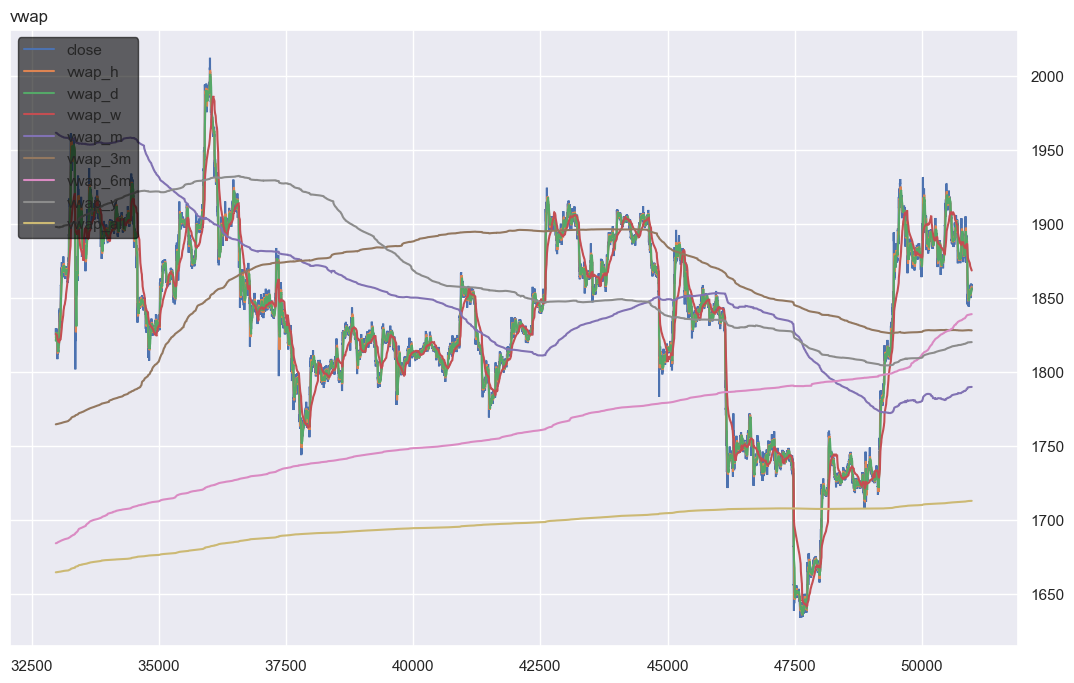

In [50]:
nb_point = 18000
fig = plt.figure()
fig.set_size_inches([13,8])
plt.plot(df_eth[-nb_point:].Close, label="close")
plt.plot(df_eth[-nb_point:]["vwap_h"], label='vwap_h')
plt.plot(df_eth[-nb_point:]["vwap_d"], label='vwap_d')
plt.plot(df_eth[-nb_point:]["vwap_w"], label='vwap_w')
plt.plot(df_eth[-nb_point:]["vwap_m"], label='vwap_m')
plt.plot(df_eth[-nb_point:]["vwap_3m"], label='vwap_3m')
plt.plot(df_eth[-nb_point:]["vwap_6m"], label='vwap_6m')
plt.plot(df_eth[-nb_point:]["vwap_y"], label='vwap_y')
plt.plot(df_eth[-nb_point:]["vwap_all"], label='vwap_all')
plt.title('vwap')
plt.legend()
plt.show()

- MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [51]:
# MVRV Z-score : (Market Value - Realized Value) / Std(Market Value)
# approximated by : (Close - VWAP(all time) ) / Std(Close from first date)
# nb_max_period = df_eth.shape[0]

df_eth["vwap_z_score"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"].expanding(1).std()
df_btc["vwap_z_score"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"].expanding(1).std()
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,chop_w,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,NaN,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,NaN,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,NaN,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,NaN,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,NaN,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,43.669234,1857.144422,1854.611845,1868.989274,1789.763954,1828.032752,1838.952405,1820.051213,1712.762494,0.773285
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,43.672239,1857.040923,1854.754446,1868.900302,1789.761718,1828.030180,1838.956465,1820.052982,1712.763550,0.790993
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,43.675232,1857.082797,1854.968859,1868.715196,1789.762917,1828.015099,1838.962944,1820.055445,1712.764814,0.794022
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,43.678203,1856.962547,1855.395739,1868.616801,1789.759237,1828.005054,1838.965887,1820.056581,1712.765206,0.791857


NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on all times



In [52]:
# NUPL 
df_eth["nupl"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"]
df_btc["nupl"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"]
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,1857.144422,1854.611845,1868.989274,1789.763954,1828.032752,1838.952405,1820.051213,1712.762494,0.773285,0.076947
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,1857.040923,1854.754446,1868.900302,1789.761718,1828.030180,1838.956465,1820.052982,1712.763550,0.790993,0.078570
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,1857.082797,1854.968859,1868.715196,1789.762917,1828.015099,1838.962944,1820.055445,1712.764814,0.794022,0.078847
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,1856.962547,1855.395739,1868.616801,1789.759237,1828.005054,1838.965887,1820.056581,1712.765206,0.791857,0.078648


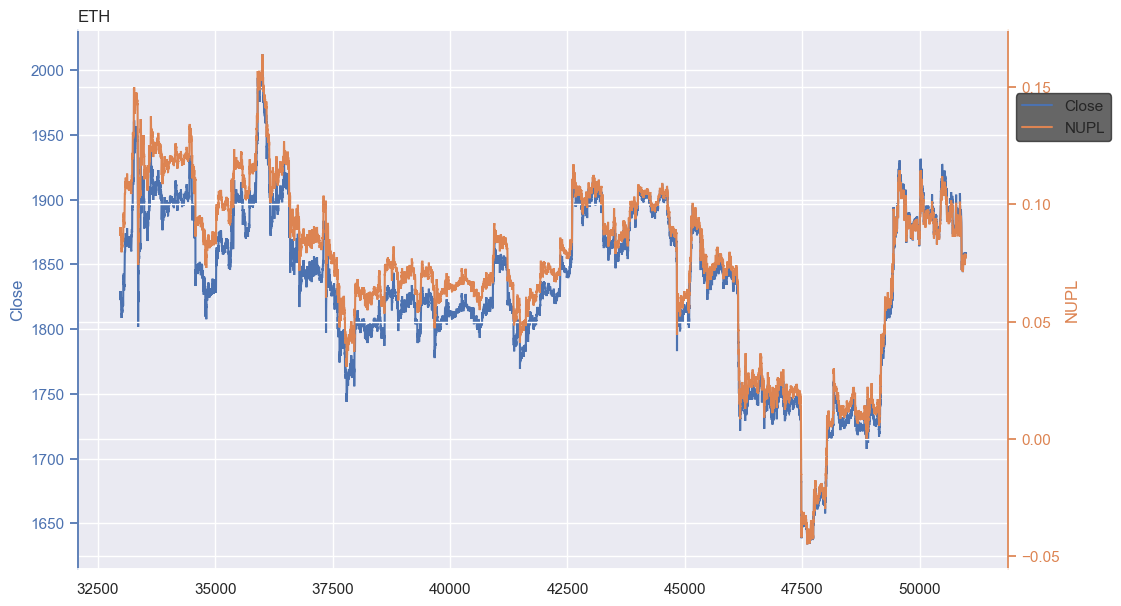

In [53]:
nb_point = 18000



fig, ax1 = plt.subplots()
fig.set_size_inches([12,7])
ax1.plot(df_eth[-nb_point:].Close)
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title('ETH')

ax2 = ax1.twinx()
ax2.plot(df_eth[-nb_point:]["nupl"],'C1')
ax2.set_ylabel('NUPL', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(['Close','NUPL'], bbox_to_anchor=(0.9, 0.8))

plt.show()

## Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [54]:
# https://api.alternative.me/fng/?limit=370&format=csv
nb_days = int(np.ceil(df_eth.shape[0]/24))
response = requests.get(f"https://api.alternative.me/fng/?limit={nb_days}")

d_fear = json.loads(response.text)
nb_days = len(d_fear["data"])
df_fear = pd.DataFrame(
    [int(d_fear["data"][i_time]["timestamp"])*1000 
     for i_time in range(nb_days) ], columns=["Time"])
df_fear["fear_greed"] = [
    int(d_fear["data"][i_time]["value"]) 
    for i_time in range(nb_days)]
df_fear["fear_greed_class"] = [
    d_fear["data"][i_time]["value_classification"]
    for i_time in range(nb_days)]

df_eth = df_eth.merge(df_fear, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_eth["fear_greed"] = df_eth["fear_greed"].ffill()
df_eth["fear_greed_class"] = df_eth["fear_greed_class"].ffill()
df_eth.loc[df_eth["fear_greed"].isna(), "fear_greed"] = 50
df_eth.loc[df_eth["fear_greed_class"].isna(), "fear_greed_class"] = "Neutral"
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,1868.989274,1789.763954,1828.032752,1838.952405,1820.051213,1712.762494,0.773285,0.076947,55.0,Greed
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,1868.900302,1789.761718,1828.030180,1838.956465,1820.052982,1712.763550,0.790993,0.078570,55.0,Greed
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,1868.715196,1789.762917,1828.015099,1838.962944,1820.055445,1712.764814,0.794022,0.078847,55.0,Greed
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,1868.616801,1789.759237,1828.005054,1838.965887,1820.056581,1712.765206,0.791857,0.078648,55.0,Greed


In [55]:
df_eth.head(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear
5,1672532700000,1196.06,1196.70,1196.06,1196.61,394.9124,2023-01-01 00:25:00,1718.529243,1717.870567,NaN,...,1195.754893,1195.754893,1195.754893,1195.754893,1195.754893,1195.754893,1.150158,0.000715,26.0,Fear
6,1672533000000,1196.62,1196.62,1193.72,1194.36,497.8406,2023-01-01 00:30:00,1718.529243,1717.870567,NaN,...,1195.607388,1195.607388,1195.607388,1195.607388,1195.607388,1195.607388,-1.427337,-0.001044,26.0,Fear
7,1672533300000,1194.37,1194.43,1192.72,1194.22,1299.5971,2023-01-01 00:35:00,1718.529243,1717.870567,NaN,...,1195.043013,1195.043013,1195.043013,1195.043013,1195.043013,1195.043013,-0.869632,-0.000689,26.0,Fear
8,1672533600000,1194.22,1194.22,1193.02,1193.64,409.5032,2023-01-01 00:40:00,1718.529243,1717.870567,NaN,...,1194.916773,1194.916773,1194.916773,1194.916773,1194.916773,1194.916773,-1.194916,-0.001070,26.0,Fear
9,1672533900000,1193.64,1195.06,1193.63,1194.64,521.0221,2023-01-01 00:45:00,1718.529243,1717.870567,NaN,...,1194.868552,1194.868552,1194.868552,1194.868552,1194.868552,1194.868552,-0.223011,-0.000191,26.0,Fear


In [56]:
df_eth.tail(25)

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
50952,1687816800000,1850.80,1850.81,1847.02,1849.83,2209.2892,2023-06-26 22:00:00,1849.8700,1865.590,1852.690,...,1870.822919,1789.698583,1828.083231,1838.826284,1820.007179,1712.737836,0.742429,0.074111,55.0,Greed
50953,1687817100000,1849.83,1851.57,1849.13,1850.06,911.4391,2023-06-26 22:05:00,1849.8700,1864.705,1852.690,...,1870.694701,1789.702547,1828.082155,1838.830944,1820.009795,1712.739358,0.743670,0.074225,55.0,Greed
50954,1687817400000,1850.05,1854.37,1850.05,1853.70,1640.7112,2023-06-26 22:10:00,1850.5425,1864.705,1852.690,...,1870.552395,1789.708196,1828.081959,1838.838722,1820.014908,1712.742146,0.763371,0.076041,55.0,Greed
50955,1687817700000,1853.70,1855.73,1853.70,1855.03,712.9295,2023-06-26 22:15:00,1850.5425,1864.515,1852.690,...,1870.450755,1789.710942,1828.081231,1838.842670,1820.017291,1712.743376,0.770570,0.076703,55.0,Greed
50956,1687818000000,1855.04,1855.56,1854.62,1855.32,535.8467,2023-06-26 22:20:00,1851.0375,1863.935,1852.690,...,1870.397063,1789.714139,1828.079714,1838.849686,1820.018817,1712.744302,0.772139,0.076847,55.0,Greed
50957,1687818300000,1855.32,1855.60,1855.00,1855.60,413.0004,2023-06-26 22:25:00,1852.1400,1863.935,1852.425,...,1870.356375,1789.715479,1828.075514,1838.854693,1820.019936,1712.745018,0.773655,0.076986,55.0,Greed
50958,1687818600000,1855.59,1859.20,1855.59,1859.20,910.8916,2023-06-26 22:30:00,1852.4350,1863.935,1853.110,...,1870.285675,1789.722943,1828.074718,1838.861832,1820.022953,1712.746624,0.793146,0.078772,55.0,Greed
50959,1687818900000,1859.19,1859.51,1858.20,1859.22,697.8192,2023-06-26 22:35:00,1852.6450,1863.540,1853.265,...,1870.241607,1789.726945,1828.073043,1838.866871,1820.025532,1712.747863,0.793251,0.078781,55.0,Greed
50960,1687819200000,1859.21,1859.60,1858.64,1859.41,599.7338,2023-06-26 22:40:00,1852.8775,1863.540,1853.310,...,1870.157180,1789.731359,1828.071435,1838.872348,1820.027459,1712.748929,0.794277,0.078875,55.0,Greed
50961,1687819500000,1859.41,1860.42,1857.62,1858.01,908.6654,2023-06-26 22:45:00,1852.8100,1862.925,1853.720,...,1869.963212,1789.737184,1828.070425,1838.876249,1820.030785,1712.750539,0.786690,0.078180,55.0,Greed


## Daily economic infos 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago : NOK
- STH-MVRV ? equiv to Price / VWAP of the last 6 months : NOK
- Dave’s Logarithmic Growth Curve ? : NOK

Others tickers:

- US02Y no but US05Y from yahoo finance
- ETHBTC : to be calculated
- SP500
- DXY

TODO ? 
- open interest 
- NASDAC


US02Y : 

In [57]:
datetime.strptime(FIRST_DATE, "%Y-%m-%d %H:%M:%S")

datetime.datetime(2023, 1, 1, 0, 0)

openbb  for index is not good about datetime and DXY no data

In [58]:
openbb.economy.available_indices()

{'sp500': {'name': 'S&P 500 Index', 'ticker': '^GSPC'},
 'sp400': {'name': 'S&P 400 Mid Cap Index', 'ticker': '^SP400'},
 'sp600': {'name': 'S&P 600 Small Cap Index', 'ticker': '^SP600'},
 'sp500tr': {'name': 'S&P 500 TR Index', 'ticker': '^SP500TR'},
 'sp_xsp': {'name': 'S&P 500 Mini SPX Options Index', 'ticker': '^XSP'},
 'nyse_ny': {'name': 'NYSE US 100 Index', 'ticker': '^NY'},
 'dow_djus': {'name': 'Dow Jones US Index', 'ticker': '^DJUS'},
 'nyse': {'name': 'NYSE Composite Index', 'ticker': '^NYA'},
 'amex': {'name': 'NYSE-AMEX Composite Index', 'ticker': '^XAX'},
 'nasdaq': {'name': 'Nasdaq Composite Index', 'ticker': '^IXIC'},
 'nasdaq100': {'name': 'NASDAQ 100', 'ticker': '^NDX'},
 'nasdaq100_ew': {'name': 'NASDAQ 100 Equal Weighted Index',
  'ticker': '^NDXE'},
 'nasdaq50': {'name': 'NASDAQ Q50 Index', 'ticker': '^NXTQ'},
 'russell1000': {'name': 'Russell 1000 Index', 'ticker': '^RUI'},
 'russell2000': {'name': 'Russell 2000 Index', 'ticker': '^RUT'},
 'cboe_bxr': {'name': 'CB

In [59]:
openbb.economy.treasury(instruments=["nominal"], maturities=["2y"], frequency="daily", start_date="2023-01-01")

,Nominal_2-year
TIME_PERIOD,
2023-01-03,4.40
2023-01-04,4.36
2023-01-05,4.45
2023-01-06,4.24
2023-01-09,4.19
...,...
2023-06-15,4.62
2023-06-16,4.70
2023-06-20,4.68


In [60]:
def req_yf_date(ticker):
    data = yf.Ticker(ticker).history(interval="1h", period="2y")
    # date
    data["date"] = pd.to_datetime(data.index, utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    data["Time"] = data["date"].apply(exchange.parse8601)
    data["date"] = pd.to_datetime(data["date"],  utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    data = data.reset_index()
    print("First date: ", data["Datetime"].values[0])
    print("Last date: ", data["Datetime"].values[-1])
    # data = data[["Time", "date", "Close"]]
    return data

def add_ticker_data(symbol, path_data):
    """
    Merge new data
    not optimized : download all new data and merge
    """
    df_new = req_yf_date(symbol)
    if os.path.isfile(path_data):
        df = pd.read_csv(path_data)
        list_col = df.columns
        if df["Time"].values[-1] < df_new["Time"].values[-1]:
            print("New data available...")
            df = df.merge(df_new, 
                left_on='Time', 
                right_on='Time', 
                how="outer",
                suffixes=("", "_new")
            )
            for col in list_col:
                if col != 'Time':
                    df.loc[df[col].isna(), col] = df.loc[df[col].isna(), f"{col}_new"]

            df = df[list_col]
            df.to_csv(path_data, index=False)

        return df
    else:
        df_new.to_csv(path_data, index=False)
        return df_new

U.S. Treasury Yield 5 Years

In [61]:
#df_fvx = yf.Ticker("^FVX").history(interval="1h", period="2y")
path_fvx = os.path.join(PATH_DATA, "df_fvx.csv")
df_fvx = add_ticker_data("^FVX", path_fvx)
df_fvx

First date:  2021-06-28T12:00:00.000000000
Last date:  2023-06-26T18:00:00.000000000


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 08:00:00-05:00,0.514,0.524,0.514,0.521,0.0,0.0,0.0,2021-02-16 13:00:00,1613480400000
1,2021-02-16 09:00:00-05:00,0.521,0.527,0.516,0.527,0.0,0.0,0.0,2021-02-16 14:00:00,1613484000000
2,2021-02-16 10:00:00-05:00,0.529,0.532,0.522,0.529,0.0,0.0,0.0,2021-02-16 15:00:00,1613487600000
3,2021-02-16 11:00:00-05:00,0.529,0.553,0.529,0.551,0.0,0.0,0.0,2021-02-16 16:00:00,1613491200000
4,2021-02-16 12:00:00-05:00,0.551,0.553,0.545,0.546,0.0,0.0,0.0,2021-02-16 17:00:00,1613494800000
...,...,...,...,...,...,...,...,...,...,...
4144,2023-06-26 10:00:00-04:00,3.972,3.986,3.964,3.977,0.0,0.0,0.0,2023-06-26 14:00:00,1687788000000
4145,2023-06-26 11:00:00-04:00,3.977,3.977,3.950,3.975,0.0,0.0,0.0,2023-06-26 15:00:00,1687791600000
4146,2023-06-26 12:00:00-04:00,3.975,3.980,3.964,3.964,0.0,0.0,0.0,2023-06-26 16:00:00,1687795200000
4147,2023-06-26 13:00:00-04:00,3.966,3.973,3.957,3.963,0.0,0.0,0.0,2023-06-26 17:00:00,1687798800000


SPX

In [62]:
# S&P 500 = "^GSPC"
# df_spx = yf.Ticker("^GSPC").history(interval="1h", period="2y")
path_sp500 = os.path.join(PATH_DATA, "df_sp500.csv")
df_sp500 = add_ticker_data("^GSPC", path_sp500)
df_sp500

First date:  2021-06-28T13:30:00.000000000
Last date:  2023-06-26T19:30:00.000000000


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
4145,2023-06-26 11:30:00-04:00,4340.919922,4348.819824,4334.560059,4339.509766,251740966.0,0.0,0.0,2023-06-26 15:30:00,1687793400000
4146,2023-06-26 12:30:00-04:00,4339.549805,4342.379883,4332.879883,4342.120117,197209740.0,0.0,0.0,2023-06-26 16:30:00,1687797000000
4147,2023-06-26 13:30:00-04:00,4342.109863,4342.669922,4333.709961,4336.870117,173641000.0,0.0,0.0,2023-06-26 17:30:00,1687800600000
4148,2023-06-26 14:30:00-04:00,4336.930176,4345.080078,4336.589844,4342.419922,208997000.0,0.0,0.0,2023-06-26 18:30:00,1687804200000


DXY

In [63]:
#df_dxy = yf.Ticker("DX-Y.NYB").history(interval="1h", period="2y")
path_dxy = os.path.join(PATH_DATA, "df_dxy.csv")
df_dxy = add_ticker_data("DX-Y.NYB", path_dxy)   
df_dxy

First date:  2021-06-27T21:00:00.000000000
Last date:  2023-06-27T00:00:00.000000000
New data available...


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 00:00:00-05:00,90.290001,90.334000,90.280998,90.305000,0.0,0.0,0.0,2021-02-16 05:00:00,1613451600000
1,2021-02-16 01:00:00-05:00,90.306000,90.329002,90.292999,90.294998,0.0,0.0,0.0,2021-02-16 06:00:00,1613455200000
2,2021-02-16 02:00:00-05:00,90.294998,90.375000,90.277000,90.362999,0.0,0.0,0.0,2021-02-16 07:00:00,1613458800000
3,2021-02-16 03:00:00-05:00,90.362000,90.369003,90.205002,90.218002,0.0,0.0,0.0,2021-02-16 08:00:00,1613462400000
4,2021-02-16 04:00:00-05:00,90.218002,90.269997,90.202003,90.220001,0.0,0.0,0.0,2021-02-16 09:00:00,1613466000000
...,...,...,...,...,...,...,...,...,...,...
14438,2023-06-26 16:00:00-04:00,102.761002,102.779999,102.745003,102.769997,0.0,0.0,0.0,2023-06-26 20:00:00,1687809600000
14439,2023-06-26 17:00:00-04:00,102.769997,102.769997,102.749001,102.760002,0.0,0.0,0.0,2023-06-26 21:00:00,1687813200000
14440,2023-06-26 18:00:00-04:00,102.761002,102.762001,102.752998,102.753998,0.0,0.0,0.0,2023-06-26 22:00:00,1687816800000
14441,2023-06-26 19:00:00-04:00,102.737000,102.742996,102.730003,102.738998,0.0,0.0,0.0,2023-06-26 23:00:00,1687820400000


In [64]:
df_sp500

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time
0,2021-02-16 09:30:00-05:00,3939.610107,3950.429932,3936.909912,3948.080078,0.0,0.0,0.0,2021-02-16 14:30:00,1613485800000
1,2021-02-16 10:30:00-05:00,3948.149902,3950.060059,3932.590088,3934.110107,300457448.0,0.0,0.0,2021-02-16 15:30:00,1613489400000
2,2021-02-16 11:30:00-05:00,3932.379883,3937.379883,3923.850098,3936.729980,252237147.0,0.0,0.0,2021-02-16 16:30:00,1613493000000
3,2021-02-16 12:30:00-05:00,3936.639893,3938.850098,3933.129883,3937.399902,180931202.0,0.0,0.0,2021-02-16 17:30:00,1613496600000
4,2021-02-16 13:30:00-05:00,3937.429932,3939.989990,3933.239990,3939.929932,185999714.0,0.0,0.0,2021-02-16 18:30:00,1613500200000
...,...,...,...,...,...,...,...,...,...,...
4145,2023-06-26 11:30:00-04:00,4340.919922,4348.819824,4334.560059,4339.509766,251740966.0,0.0,0.0,2023-06-26 15:30:00,1687793400000
4146,2023-06-26 12:30:00-04:00,4339.549805,4342.379883,4332.879883,4342.120117,197209740.0,0.0,0.0,2023-06-26 16:30:00,1687797000000
4147,2023-06-26 13:30:00-04:00,4342.109863,4342.669922,4333.709961,4336.870117,173641000.0,0.0,0.0,2023-06-26 17:30:00,1687800600000
4148,2023-06-26 14:30:00-04:00,4336.930176,4345.080078,4336.589844,4342.419922,208997000.0,0.0,0.0,2023-06-26 18:30:00,1687804200000


merge with df_eth

In [65]:
df_eth[df_eth["date"] == "2023-02-16 16:00:00"]

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_w,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class
13440,1676563200000,1724.14,1742.97,1723.15,1740.25,15652.277,2023-02-16 16:00:00,1682.43,1682.43,1704.105,...,1691.967459,1600.472878,1529.969567,1529.969567,1597.951882,1529.969567,1.4078,0.120833,62.0,Greed


In [66]:
df_sp500[df_sp500["date"] == "2023-02-16 16:00:00"]

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,Time


In [67]:

df_yf_in = df_sp500[["Time", "Close"]].copy()
df_yf_in.rename(columns={"Close": "spx"}, inplace=True)
df_yf_in

,Time,spx
0,1613485800000,3948.080078
1,1613489400000,3934.110107
2,1613493000000,3936.729980
3,1613496600000,3937.399902
4,1613500200000,3939.929932
...,...,...
4145,1687793400000,4339.509766
4146,1687797000000,4342.120117
4147,1687800600000,4336.870117
4148,1687804200000,4342.419922


In [68]:
pd.to_datetime(df_fvx["date"].iloc[0]).minute != 0

False

In [69]:
print(df_sp500["date"].iloc[0])
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
if nb_minutes != 0:
    print(df_sp500["Time"].iloc[0])
    timestamp_new = df_sp500["Time"].iloc[0] + (60 - nb_minutes) * 60 * 1000
    print(datetime.fromtimestamp(timestamp_new/1000, tz=timezone.utc))


2021-02-16 14:30:00
1613485800000
2021-02-16 15:00:00+00:00


In [70]:
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
df_spx = df_sp500.copy()
df_spx["Time"] = df_spx["Time"] + (60 - nb_minutes) * 60 * 1000


In [71]:
df_test = df_eth.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_test["spx"].notna().value_counts()

False    50137
True       840
Name: spx, dtype: int64

In [72]:
# merge with df_eth
def merge_daily_yf(df, df_yf, name):
    df_in = df.copy()
    df_yf_in = df_yf.copy()
    # check if minutes
    nb_minutes = pd.to_datetime(df_yf_in["date"].iloc[0]).minute
    if nb_minutes != 0:
        df_yf_in["Time"] = df_yf_in["Time"] + (60 - nb_minutes) * 60 * 1000
    

    df_yf_in = df_yf_in[["Time", "Close"]]
    df_yf_in.rename(columns={"Close": name}, inplace=True)
    df_in = df_in.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    df_in[name] = df_in[name].ffill()
    
    return df_in

df_eth_merge = merge_daily_yf(df_eth, df_fvx, "fvx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_sp500, "spx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_dxy, "dxy")

df_eth_merge

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,1196.096667,1196.096667,1196.096667,NaN,0.000187,26.0,Fear,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,26.0,Fear,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,26.0,Fear,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,1195.575250,1195.575250,1195.575250,0.521593,0.000338,26.0,Fear,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,1195.615807,1195.615807,1195.615807,0.626856,0.000371,26.0,Fear,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,1838.952405,1820.051213,1712.762494,0.773285,0.076947,55.0,Greed,3.963,4328.819824,102.738998
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,1838.956465,1820.052982,1712.763550,0.790993,0.078570,55.0,Greed,3.963,4328.819824,102.738998
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,1838.962944,1820.055445,1712.764814,0.794022,0.078847,55.0,Greed,3.963,4328.819824,102.738998
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,1838.965887,1820.056581,1712.765206,0.791857,0.078648,55.0,Greed,3.963,4328.819824,102.738998


In [73]:
df_eth = df_eth_merge.copy()

## Economy calendar

In [74]:
help(openbb.economy.events)

Help on Operation in module openbb_terminal.core.library.operation:

<openbb_terminal.core.library.operation.Operation object>
    Get economic calendar for countries between specified dates
    
    Parameters
    ----------
    countries : [List[str],str]
        List of countries to include in calendar.  Empty returns all
    start_date : Optional[str]
        Start date for calendar
    end_date : Optional[str]
        End date for calendar
    
    Returns
    -------
    pd.DataFrame
        Economic calendar
    
    Examples
    --------
    Get todays economic calendar for the United States
    >>> from openbb_terminal.sdk import openbb
    >>> calendar = openbb.economy.events("united_states")
    
    To get multiple countries for a given date, pass the same start and end date as well as
    a list of countries
    >>> calendars = openbb.economy.events(["united_states", "canada"], start_date="2022-11-18", end_date="2022-11-18")



In [75]:
os.path.isfile(path_save_df_eco)

True

In [76]:
# Time : timestamp unix UTC
# date : string UTC
def reduce_date_str(str_date):
    date_obj = datetime.strptime(str_date, "%Y-%m-%d %H:%M:%S")
    return date_obj.strftime("%Y-%m-%d")

def add_days(str_date_0, nb_days_CV, date_format="%Y-%m-%d"):
    '''
    add days to string dates
    '''
    date_last = datetime.strptime(str_date_0, date_format)
    date_start = date_last + timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def update_eco_data(df_eco):
    """
    Update with new data.
    Add one day after last date LAST_DATE
    and update Actual data
    """
    # Find last Actual data to find the last update time 
    last_actual_data = df_eco[df_eco["Actual"] != '-']["Date"].iloc[-1]
    print("start date to download: ", last_actual_data)
    # Take it as First date to download data
    last_new_date_eco = reduce_date_str(add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    print("end date to download: ",  last_new_date_eco)
    # Download data
    df_eco_new = openbb.economy.events(
        start_date=last_actual_data, 
        end_date=last_new_date_eco,
        countries = ['United States'],
    )
    print("df_eco_new.shape: ", df_eco_new.shape)
    # Merge new data and update Actual info
    df_eco_last = pd.concat([df_eco, df_eco_new], ignore_index=True)
    print("df_eco.shape: ", df_eco.shape)
    print("Before : df_eco_last.shape: ", df_eco_last.shape)
    df_eco_last = df_eco_last.drop_duplicates(
        subset=["Event", "Date", "Time (ET)"], keep="last")
    print("After : df_eco_last.shape: ", df_eco_last.shape)

    return df_eco_last

In [77]:
if os.path.isfile(path_save_df_eco):
    df_eco = pd.read_csv(path_save_df_eco)
    df_eco = update_eco_data(df_eco)
    df_eco.to_csv(path_save_df_eco, index=False)
    
else:
    last_new_date_eco = reduce_date_str(
        add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    df_eco = openbb.economy.events(start_date="2021-01-01",
                                   end_date=last_new_date_eco,
                                   countries = ['United States'])
    df_eco.to_csv(path_save_df_eco,index=False)
    
df_eco

start date to download:  2023-06-08
end date to download:  2023-06-28


df_eco_new.shape:  (229, 7)
df_eco.shape:  (10751, 7)
Before : df_eco_last.shape:  (10980, 7)
After : df_eco_last.shape:  (10960, 7)


,Time (ET),Country,Event,Actual,Consensus,Previous,Date
0,All Day,United States,United States - New Year's Day,-,-,-,2021-01-01
1,09:45,United States,Manufacturing PMI,57.1,-,56.5,2021-01-04
2,10:00,United States,Chicago Fed President Evans Speaks,-,-,-,2021-01-04
3,10:00,United States,Construction Spending,0.9%,1.0%,1.6%,2021-01-04
4,10:00,United States,FOMC Member Bostic Speaks,-,-,-,2021-01-04
...,...,...,...,...,...,...,...
10975,10:30,United States,Heating Oil Stockpiles,-,-0.034M,-0.380M,2023-06-28
10976,10:30,United States,EIA Weekly Refinery Utilization Rates,-,-,-0.6%,2023-06-28
10977,10:30,United States,Gasoline Inventories,-,1.359M,0.479M,2023-06-28
10978,13:00,United States,7-Year Note Auction,-,-,3.827%,2023-06-28


Filter events
- Core CPI
- PPI
- Fed Interest Rate Decision

In [78]:
# Core CPI : The core consumer price inflation rate in the United States
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="Core CPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
133,08:30,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13
491,08:30,United States,Core CPI,1.4%,1.5%,1.6%,2021-02-10
858,08:30,United States,Core CPI,0.1%,0.2%,0.1%,2021-03-10
1276,07:30,United States,Core CPI,1.6%,1.5%,1.3%,2021-04-13
1649,07:30,United States,Core CPI,0.9%,0.3%,0.3%,2021-05-12
2020,07:30,United States,Core CPI,3.8%,3.4%,3.0%,2021-06-10
2379,07:30,United States,Core CPI,4.5%,4.0%,3.8%,2021-07-13
2730,07:30,United States,Core CPI,4.3%,4.3%,4.5%,2021-08-11
3115,07:30,United States,Core CPI,0.1%,0.3%,0.3%,2021-09-14
3474,07:30,United States,Core CPI,4.0%,4.0%,4.0%,2021-10-13


In [79]:
# PPI : United States Producer Price Inflation 
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] =="PPI"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
174,08:30,United States,PPI,0.8%,0.8%,0.8%,2021-01-15
566,08:30,United States,PPI,1.3%,0.4%,0.3%,2021-02-17
889,08:30,United States,PPI,2.8%,2.7%,1.7%,2021-03-12
1247,07:30,United States,PPI,4.2%,3.8%,2.8%,2021-04-09
1678,07:30,United States,PPI,0.6%,0.3%,1.0%,2021-05-13
2062,07:30,United States,PPI,0.8%,0.6%,0.6%,2021-06-15
2401,07:30,United States,PPI,1.0%,0.6%,0.8%,2021-07-14
2759,07:30,United States,PPI,7.8%,7.3%,7.3%,2021-08-12
3090,07:30,United States,PPI,0.7%,0.6%,1.0%,2021-09-10
3494,07:30,United States,PPI,0.5%,0.6%,0.7%,2021-10-14


In [80]:
# Fed interesst rate
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
df_eco[df_eco["Event"] == "Fed Interest Rate Decision"]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27
958,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-03-17
1464,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-04-28
2107,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-06-16
2563,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-07-28
3222,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-09-22
3766,13:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-11-03
4291,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-12-15
4751,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2022-01-26
5371,13:00,United States,Fed Interest Rate Decision,0.50%,0.50%,0.25%,2022-03-16


In [81]:
# sentiment = -1 by default
df_eco[df_eco["Event"].str.contains("FOMC Meeting Minutes")]

,Time (ET),Country,Event,Actual,Consensus,Previous,Date
58,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-01-06
580,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-02-17
1236,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-04-07
1752,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-05-19
2331,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-07-07
2827,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-08-18
3484,13:00,United States,FOMC Meeting Minutes,-,-,-,2021-10-13
4047,14:00,United States,FOMC Meeting Minutes,-,-,-,2021-11-24
4510,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-01-05
5023,14:00,United States,FOMC Meeting Minutes,-,-,-,2022-02-16


In [82]:
list_filter_eco = ["Fed Interest Rate Decision", "Core CPI", "PPI"]
for value in list_filter_eco:
    print(f'{value} : {df_eco[df_eco["Event"] == value].shape[0]}')
    print(df_eco[df_eco["Event"] == value]["Event"])

def apply_eco_filter(str_event):
    if str_event in list_filter_eco:
        return 1
    else:
        return 0

df_eco_filter = df_eco.copy()
df_eco_filter["keep"] = df_eco_filter["Event"].apply(apply_eco_filter)
df_eco_filter.loc[df_eco_filter["Time (ET)"] == "All Day" ,"keep"]  = 1
df_eco_filter = df_eco_filter.loc[df_eco_filter["keep"] == 1]


def apply_ppc_to_num(str_ppc):
    if str_ppc == "-":
        return 0
    return float(str_ppc[:-1])

def apply_norm_event(delta_value):
    if delta_value > 0:
        return +1
    elif delta_value == 0:
        return 0
    else:
        return -1

# ppc to num
df_eco_filter["Actual_num"] = df_eco_filter["Actual"].apply(apply_ppc_to_num)
df_eco_filter["Consensus_num"] = df_eco_filter["Consensus"].apply(apply_ppc_to_num)
df_eco_filter["Previous_num"] = df_eco_filter["Previous"].apply(apply_ppc_to_num)
# delta 
# event_pred : if Previous > Consensus: +1, else -1
df_eco_filter["delta_event_pred"] = df_eco_filter["Previous_num"] - df_eco_filter["Consensus_num"]
df_eco_filter["event_pred"] = df_eco_filter["delta_event_pred"].apply(apply_norm_event)
# event_real : if Consensus > Actual: +1, else -1 
df_eco_filter["delta_event_real"] = df_eco_filter["Consensus_num"] - df_eco_filter["Actual_num"]
df_eco_filter["event_real"] = df_eco_filter["delta_event_real"].apply(apply_norm_event)

df_eco_filter.tail(20)

Fed Interest Rate Decision : 20
307      Fed Interest Rate Decision
958      Fed Interest Rate Decision
1464     Fed Interest Rate Decision
2107     Fed Interest Rate Decision
2563     Fed Interest Rate Decision
3222     Fed Interest Rate Decision
3766     Fed Interest Rate Decision
4291     Fed Interest Rate Decision
4751     Fed Interest Rate Decision
5371     Fed Interest Rate Decision
5974     Fed Interest Rate Decision
6481     Fed Interest Rate Decision
6923     Fed Interest Rate Decision
7576     Fed Interest Rate Decision
8112     Fed Interest Rate Decision
8611     Fed Interest Rate Decision
9136     Fed Interest Rate Decision
9773     Fed Interest Rate Decision
10297    Fed Interest Rate Decision
10827    Fed Interest Rate Decision
Name: Event, dtype: object
Core CPI : 31
133      Core CPI
491      Core CPI
858      Core CPI
1276     Core CPI
1649     Core CPI
2020     Core CPI
2379     Core CPI
2730     Core CPI
3115     Core CPI
3474     Core CPI
3839     Core CPI
4220     

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real
9136,14:00,United States,Fed Interest Rate Decision,4.75%,4.75%,4.50%,2023-02-01,1,4.75,4.75,4.50,-0.25,-1,0.0,0
9235,08:30,United States,Core CPI,5.6%,5.5%,5.7%,2023-02-14,1,5.60,5.50,5.70,0.20,1,-0.1,-1
9325,08:30,United States,PPI,0.7%,0.4%,-0.2%,2023-02-16,1,0.70,0.40,-0.20,-0.60,-1,-0.3,-1
9357,08:30,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.50,1.10,1,-0.6,-1
9389,09:30,United States,PPI,6.0%,5.4%,6.5%,2023-02-17,1,6.00,5.40,6.50,1.10,1,-0.6,-1
9406,All Day,United States,United States - Washington's Birthday,-,-,-,2023-02-20,1,0.00,0.00,0.00,0.00,0,0.0,0
9664,08:30,United States,Core CPI,0.5%,0.4%,0.4%,2023-03-14,1,0.50,0.40,0.40,0.00,0,-0.1,-1
9685,08:30,United States,PPI,-0.1%,0.3%,0.3%,2023-03-15,1,-0.10,0.30,0.30,0.00,0,0.4,1
9773,14:00,United States,Fed Interest Rate Decision,5.00%,5.00%,4.75%,2023-03-22,1,5.00,5.00,4.75,-0.25,-1,0.0,0
9991,All Day,United States,United States - Good Friday,-,-,-,2023-04-07,1,0.00,0.00,0.00,0.00,0,0.0,0


Clean eco data

In [83]:
def get_round_time(time_str):
    """
    Get  round time : 
        example : 
        print(get_round_time('07:20'))
        07:00
        print(get_round_time('07:30'))
        07:00
        print(get_round_time('07:31'))
        08:00
        print(get_round_time('11:31'))
        12:00
    TODO : if time is 23:31 ? output is not good  ! 24:00 (but not into this data)
            => need to add + 1 day
    """
    if time_str == "All Day":
        return "00:00"
    str_minutes = time_str[-2:]
    str_hours = time_str[-5:-3]
    if int(str_minutes)  <= 30 : 
        return str_hours + ":00" 
    else:
        str_time = f"{int(str_hours)+1}:00"
        if len(str_time) < 5:
            str_time = "0" + str_time
        return str_time

def clean_eco_data(df_eco):
    """
    Clean agenda : remove Tentative, add day_off for All Day,
    round minutes 
    """
    df_eco_clean = df_eco.copy()
    df_eco_clean = df_eco_clean[df_eco_clean["Time (ET)"] != "Tentative"]
    df_eco_clean["day_off"] = 0
    df_eco_clean.loc[df_eco_clean["Time (ET)"] == "All Day","day_off"] = 1
    df_eco_clean.loc[
        df_eco_clean["Time (ET)"] == "All Day", "Time (ET)"] = "00:00"
    print(df_eco_clean["Time (ET)"].unique())
    df_eco_clean["Time (ET)"] = df_eco_clean["Time (ET)"].apply(get_round_time)
    print(df_eco_clean["Time (ET)"].unique())

    return df_eco_clean

def add_time_eco(df_eco):
    df = df_eco.copy() 
    # add timezone ET info
    df["date"] = df["Date"] + " " + df["Time (ET)"] + ":00-05:00"
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df

df_eco_clean = clean_eco_data(df_eco_filter)

df_eco_final = add_time_eco(df_eco_clean)

df_eco_final.tail(10)

['00:00' '08:30' '14:00' '13:00' '07:30' '09:30']
['00:00' '08:00' '14:00' '13:00' '07:00' '09:00']


,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
10013,08:00,United States,Core CPI,5.6%,5.6%,5.5%,2023-04-12,1,5.60,5.60,5.50,-0.10,-1,0.0,0,0,2023-04-12 13:00:00,1681304400000
10041,08:00,United States,PPI,2.7%,3.0%,4.9%,2023-04-13,1,2.70,3.00,4.90,1.90,1,0.3,1,0,2023-04-13 13:00:00,1681390800000
10297,14:00,United States,Fed Interest Rate Decision,5.25%,5.25%,5.00%,2023-05-03,1,5.25,5.25,5.00,-0.25,-1,0.0,0,0,2023-05-03 19:00:00,1683140400000
10359,08:00,United States,Core CPI,0.4%,0.4%,0.4%,2023-05-10,1,0.40,0.40,0.40,0.00,0,0.0,0,0,2023-05-10 13:00:00,1683723600000
10386,08:00,United States,PPI,0.2%,0.3%,-0.4%,2023-05-11,1,0.20,0.30,-0.40,-0.70,-1,0.1,1,0,2023-05-11 13:00:00,1683810000000
10599,00:00,United States,United States - Memorial Day,-,-,-,2023-05-29,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-05-29 05:00:00,1685336400000
10785,08:00,United States,Core CPI,0.4%,0.4%,0.4%,2023-06-13,1,0.40,0.40,0.40,0.00,0,0.0,0,0,2023-06-13 13:00:00,1686661200000
10809,08:00,United States,PPI,1.1%,1.5%,2.3%,2023-06-14,1,1.10,1.50,2.30,0.80,1,0.4,1,0,2023-06-14 13:00:00,1686747600000
10827,14:00,United States,Fed Interest Rate Decision,5.25%,5.25%,5.25%,2023-06-14,1,5.25,5.25,5.25,0.00,0,0.0,0,0,2023-06-14 19:00:00,1686769200000
10882,00:00,United States,United States - Juneteenth,-,-,-,2023-06-19,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-06-19 05:00:00,1687150800000


In [84]:
df_eco_final.tail(15)

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
9406,00:00,United States,United States - Washington's Birthday,-,-,-,2023-02-20,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-02-20 05:00:00,1676869200000
9664,08:00,United States,Core CPI,0.5%,0.4%,0.4%,2023-03-14,1,0.50,0.40,0.40,0.00,0,-0.1,-1,0,2023-03-14 13:00:00,1678798800000
9685,08:00,United States,PPI,-0.1%,0.3%,0.3%,2023-03-15,1,-0.10,0.30,0.30,0.00,0,0.4,1,0,2023-03-15 13:00:00,1678885200000
9773,14:00,United States,Fed Interest Rate Decision,5.00%,5.00%,4.75%,2023-03-22,1,5.00,5.00,4.75,-0.25,-1,0.0,0,0,2023-03-22 19:00:00,1679511600000
9991,00:00,United States,United States - Good Friday,-,-,-,2023-04-07,1,0.00,0.00,0.00,0.00,0,0.0,0,1,2023-04-07 05:00:00,1680843600000
10013,08:00,United States,Core CPI,5.6%,5.6%,5.5%,2023-04-12,1,5.60,5.60,5.50,-0.10,-1,0.0,0,0,2023-04-12 13:00:00,1681304400000
10041,08:00,United States,PPI,2.7%,3.0%,4.9%,2023-04-13,1,2.70,3.00,4.90,1.90,1,0.3,1,0,2023-04-13 13:00:00,1681390800000
10297,14:00,United States,Fed Interest Rate Decision,5.25%,5.25%,5.00%,2023-05-03,1,5.25,5.25,5.00,-0.25,-1,0.0,0,0,2023-05-03 19:00:00,1683140400000
10359,08:00,United States,Core CPI,0.4%,0.4%,0.4%,2023-05-10,1,0.40,0.40,0.40,0.00,0,0.0,0,0,2023-05-10 13:00:00,1683723600000
10386,08:00,United States,PPI,0.2%,0.3%,-0.4%,2023-05-11,1,0.20,0.30,-0.40,-0.70,-1,0.1,1,0,2023-05-11 13:00:00,1683810000000


In [85]:
df_eco_clean.shape[0]

109

In [86]:
df_eco_clean.drop_duplicates(subset=["Event", "Date", "Time (ET)"]).shape[0]

109

In [87]:

# USELESS : 
def get_eco_last_time(df_eco):
    time_str = df_eco.iloc[-1]["Time (ET)"]
    if  time_str == "All Day" or time_str == "Tentative":
        time_str = "00:00"

    date_str = f'{df_eco.iloc[-1]["Date"]} {time_str}:00-05:00'
    print(date_str)
    date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
    print(date_str)
    time_unix = exchange.parse8601(date_str)
    print(time_unix)
    return time_unix
    #date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%d %H:%M:%S")
    #date_str
get_eco_last_time(df_eco)

2023-06-28 16:30:00-05:00
2023-06-28T21:30:00Z
1687987800000


1687987800000

## On-Chain data : 
  - Market Supply BTC ETH : OK 
  - % Staked ETH : NOK
  - nb of address with  BTC & ETH : OK

In [88]:
# Time : timestamp unix
# date : 2000-01-01 00:00:00
def req_active_addresses(symbol, since=FIRST_DATE):
    since = datetime.fromtimestamp(
        int(pd.Timestamp(since).timestamp())).strftime("%Y-%m-%d")
    df_active = openbb.crypto.dd.active(
        symbol = symbol,
        interval = '24h',
        start_date = since,
    )
    df_active = df_active.reset_index()
    df_active.rename(columns = {
        'v': f'act_addr_{symbol}',
        't': 'date'
        }, 
        inplace = True)
    return df_active

def req_supply(symbol, since=FIRST_DATE):
    """
    request onchain data : circulating supply, active adresses, market dominance
    """
    res = requests.get('https://api.glassnode.com/v1/metrics/supply/current',
        params={
            'a': symbol, 
            'api_key': API_GLASSNODE_KEY, 
            "i": "24h",
            "s": int(pd.Timestamp(since).timestamp())
        }
    )
    # convert to pandas dataframe
    df_supply = pd.read_json(res.text, convert_dates=['t'])
    df_supply.rename(
        columns = {'v': f'supply_{symbol}', 't': 'date'}, inplace = True)
    
    # get active adresses
    print("Get active adresses...")
    df_active = req_active_addresses(symbol, since=since)    

    df_supply = df_supply.merge(
        df_active, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    # get market dominance
    print("Get market dominance...")
    df_mcapdom = openbb.crypto.dd.mcapdom(symbol=symbol, start_date=since)
    df_mcapdom = df_mcapdom.reset_index()
    df_mcapdom.rename(
        columns = {
            'marketcap_dominance': f'market_dom_{symbol}',
            'timestamp': 'date'
        }, 
        inplace = True,
    )
    # Correct last values : patch openbb data...
    if df_mcapdom[f'market_dom_{symbol}'].values[-2] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-3]:
        print("Correcting dominance value index -2:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-3,f'market_dom_{symbol}']
        )
    if df_mcapdom[f'market_dom_{symbol}'].values[-1] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-2]:
        print("Correcting dominance value index -1:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-1,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}']
        )

    df_supply = df_supply.merge(
        df_mcapdom, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    return df_supply

def get_onchain(symbol, since=FIRST_DATE):
    path_df = os.path.join(PATH_DATA, f"df_supply_{symbol}.csv")
    
    '''if os.path.isfile(path_df):
        print(f"Read from {path_df}")
        df_supply = pd.read_csv(path_df)
        last_day = datetime.fromtimestamp(
            pd.Timestamp(LAST_DATE).timestamp(), 
            tz=timezone.utc,
        ).strftime("%Y-%m-%d")
        if last_day > df_supply.iloc[-1]["date"]:
            df_supply_new = req_supply(symbol, since=df_supply.iloc[-1]["date"])
            # NOT FINISHED BECAUSE BUG INTO LAST RECEIVED DATA


        df_supply["date"] = df_supply["date"].astype(np.datetime64)
        
    else:
    '''
    df_supply = req_supply(symbol, since=since)
    df_supply.to_csv(path_df, index=False)
    print(f"Written in {path_df}")
    return df_supply


In [89]:
df_supply_btc = get_onchain("BTC")
df_supply_btc

Get active adresses...
Index(['date', 'supply_BTC', 'act_addr_BTC'], dtype='object')
Get market dominance...
Index(['date', 'supply_BTC', 'act_addr_BTC', 'market_dom_BTC'], dtype='object')
Written in data/df_supply_BTC.csv


,date,supply_BTC,act_addr_BTC,market_dom_BTC
0,2023-01-01,19249637.50,716410,39.333914
1,2023-01-02,19250612.50,848778,39.479836
2,2023-01-03,19251575.00,981638,39.255541
3,2023-01-04,19252468.75,921281,39.250146
4,2023-01-05,19253450.00,934147,38.930125
...,...,...,...,...
172,2023-06-22,19409425.00,1005960,48.795656
173,2023-06-23,19410206.25,950159,48.921991
174,2023-06-24,19411118.75,1012001,49.109445
175,2023-06-25,19412075.00,950430,49.237174


In [90]:
df_supply_eth = get_onchain("ETH")
df_supply_eth

Get active adresses...
Index(['date', 'supply_ETH', 'act_addr_ETH'], dtype='object')
Get market dominance...
Index(['date', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH'], dtype='object')
Written in data/df_supply_ETH.csv


,date,supply_ETH,act_addr_ETH,market_dom_ETH
0,2023-01-01,1.205585e+08,279900,17.807301
1,2023-01-02,1.205586e+08,335308,17.856444
2,2023-01-03,1.205585e+08,346588,17.895238
3,2023-01-04,1.205583e+08,404285,17.896766
4,2023-01-05,1.205579e+08,519571,18.175742
...,...,...,...,...
172,2023-06-22,1.199686e+08,408494,19.032104
173,2023-06-23,1.199681e+08,436908,18.978301
174,2023-06-24,1.199685e+08,381319,18.749732
175,2023-06-25,1.199692e+08,362846,18.722370


Add date/Time on data onchain

In [91]:
def add_time_onchain(df_onchain):
    df = df_onchain.copy() 
    # add timezone ET info
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df    


In [92]:
df_supply_btc["date"]

0     2023-01-01
1     2023-01-02
2     2023-01-03
3     2023-01-04
4     2023-01-05
         ...    
172   2023-06-22
173   2023-06-23
174   2023-06-24
175   2023-06-25
176   2023-06-26
Name: date, Length: 177, dtype: datetime64[ns]

In [93]:
df_supply_btc_final = add_time_onchain(df_supply_btc)

df_supply_btc_final

,date,supply_BTC,act_addr_BTC,market_dom_BTC,Time
0,2023-01-01 00:00:00,19249637.50,716410,39.333914,1672531200000
1,2023-01-02 00:00:00,19250612.50,848778,39.479836,1672617600000
2,2023-01-03 00:00:00,19251575.00,981638,39.255541,1672704000000
3,2023-01-04 00:00:00,19252468.75,921281,39.250146,1672790400000
4,2023-01-05 00:00:00,19253450.00,934147,38.930125,1672876800000
...,...,...,...,...,...
172,2023-06-22 00:00:00,19409425.00,1005960,48.795656,1687392000000
173,2023-06-23 00:00:00,19410206.25,950159,48.921991,1687478400000
174,2023-06-24 00:00:00,19411118.75,1012001,49.109445,1687564800000
175,2023-06-25 00:00:00,19412075.00,950430,49.237174,1687651200000


In [94]:
df_supply_eth_final = add_time_onchain(df_supply_eth)
df_supply_eth_final

,date,supply_ETH,act_addr_ETH,market_dom_ETH,Time
0,2023-01-01 00:00:00,1.205585e+08,279900,17.807301,1672531200000
1,2023-01-02 00:00:00,1.205586e+08,335308,17.856444,1672617600000
2,2023-01-03 00:00:00,1.205585e+08,346588,17.895238,1672704000000
3,2023-01-04 00:00:00,1.205583e+08,404285,17.896766,1672790400000
4,2023-01-05 00:00:00,1.205579e+08,519571,18.175742,1672876800000
...,...,...,...,...,...
172,2023-06-22 00:00:00,1.199686e+08,408494,19.032104,1687392000000
173,2023-06-23 00:00:00,1.199681e+08,436908,18.978301,1687478400000
174,2023-06-24 00:00:00,1.199685e+08,381319,18.749732,1687564800000
175,2023-06-25 00:00:00,1.199692e+08,362846,18.722370,1687651200000


In [95]:
# not working since 2021-01-01 : messari data with openbb:
openbb.crypto.dd.tk(symbol="BTC", coingecko_id="bitcoin")

(                Metric                                              Value
 0        Emission Type                                       Inflationary
 1  Consensus Mechanism                                      Proof-of-Work
 2    Consensus Details  Consensus\nBitcoin pioneered and currently use...
 3     Mining Algorithm                                            SHA-256
 4         Block Reward                                                  -
 5     Block time [min]                                               10.0
 6         Total Supply                                         21000000.0
 7           Max Supply                                         21000000.0
 8   Circulating Supply                                         19412981.0,
             circulating_supply
 timestamp                     
 2022-10-15          19179300.0
 2022-10-16          19180268.0
 2022-10-17          19181156.0
 2022-10-18          19182075.0
 2022-10-19          19182981.0
 ...                     

Merge with df_eth

In [96]:
def merge_onchain(df_eth, df_supply_eth_final, list_col):
    df_eth_final = df_eth.merge(df_supply_eth_final[list_col + ["Time"]], how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    #supply_ETH	act_addr_ETH	market_dom_ETH
    for col in list_col:
        df_eth_final[col] = df_eth_final[col].ffill()

    return df_eth_final


In [97]:
list_col = ["supply_ETH",	"act_addr_ETH",	"market_dom_ETH"]
df_eth_final = merge_onchain(df_eth, df_supply_eth_final, list_col)
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_z_score,nupl,fear_greed,fear_greed_class,fvx,spx,dxy,supply_ETH,act_addr_ETH,market_dom_ETH
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,NaN,0.000187,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.807301
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,-0.634018,-0.000353,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.807301
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,-1.240604,-0.000920,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.807301
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,0.521593,0.000338,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.807301
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,0.626856,0.000371,26.0,Fear,NaN,NaN,NaN,1.205585e+08,279900.0,17.807301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,0.773285,0.076947,55.0,Greed,3.963,4328.819824,102.738998,1.199697e+08,406678.0,19.029543
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,0.790993,0.078570,55.0,Greed,3.963,4328.819824,102.738998,1.199697e+08,406678.0,19.029543
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,0.794022,0.078847,55.0,Greed,3.963,4328.819824,102.738998,1.199697e+08,406678.0,19.029543
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,0.791857,0.078648,55.0,Greed,3.963,4328.819824,102.738998,1.199697e+08,406678.0,19.029543


In [98]:
list_col = ["supply_BTC", "act_addr_BTC",	"market_dom_BTC"]
df_btc_final = merge_onchain(df_btc, df_supply_btc_final, list_col)
df_btc_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,vwap_m,vwap_3m,vwap_6m,vwap_y,vwap_all,vwap_z_score,nupl,supply_BTC,act_addr_BTC,market_dom_BTC
0,1672531200000,16541.77,16544.76,16527.51,16535.38,486.60903,2023-01-01 00:00:00,25292.991225,25282.001453,NaN,...,16535.883333,16535.883333,16535.883333,16535.883333,16535.883333,NaN,-0.000030,19249637.50,716410.0,39.333914
1,1672531500000,16534.91,16540.43,16522.55,16526.67,391.19043,2023-01-01 00:05:00,25292.991225,25282.001453,NaN,...,16533.209439,16533.209439,16533.209439,16533.209439,16533.209439,-1.061787,-0.000396,19249637.50,716410.0,39.333914
2,1672531800000,16526.67,16530.87,16520.00,16520.69,294.73889,2023-01-01 00:10:00,25292.991225,25282.001453,NaN,...,16530.857612,16530.857612,16530.857612,16530.857612,16530.857612,-1.376390,-0.000615,19249637.50,716410.0,39.333914
3,1672532100000,16521.26,16537.73,16517.72,16534.94,481.18777,2023-01-01 00:15:00,25292.991225,25282.001453,NaN,...,16530.645897,16530.645897,16530.645897,16530.645897,16530.645897,0.607749,0.000260,19249637.50,716410.0,39.333914
4,1672532400000,16534.94,16540.66,16532.33,16535.54,309.53189,2023-01-01 00:20:00,25292.991225,25282.001453,NaN,...,16531.517891,16531.517891,16531.517891,16531.517891,16531.517891,0.600029,0.000243,19249637.50,716410.0,39.333914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,30244.64,30244.64,30228.00,30239.27,25.68563,2023-06-26 23:40:00,30190.337500,30118.480000,30180.500,...,27815.060787,27406.720174,27236.037049,27461.769130,23558.945574,1.901544,0.220916,19412981.25,1006257.0,49.312505
50973,1687823100000,30239.28,30286.63,30239.27,30285.80,88.63094,2023-06-26 23:45:00,30190.337500,30173.480000,30192.815,...,27815.548923,27406.774059,27236.439189,27461.982381,23558.965243,1.914764,0.222112,19412981.25,1006257.0,49.312505
50974,1687823400000,30285.80,30286.63,30273.75,30273.76,45.33353,2023-06-26 23:50:00,30190.337500,30173.480000,30192.815,...,27815.777236,27406.683296,27236.799210,27462.092871,23558.975314,1.911315,0.221802,19412981.25,1006257.0,49.312505
50975,1687823700000,30273.76,30273.76,30264.98,30267.99,30.55664,2023-06-26 23:55:00,30190.337500,30173.480000,30192.815,...,27815.986630,27406.573570,27237.166990,27462.470954,23558.982094,1.909652,0.221654,19412981.25,1006257.0,49.312505


In [99]:
df_eth = df_eth_final.copy()
df_btc = df_btc_final.copy()

## Temporal info
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

In [100]:
# add sin/cos of hour/day/week/month/year/halving cycle (maybe to short if only 2 year) ?

# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?

pd.to_datetime(df_eth["date"])

0       2023-01-01 00:00:00
1       2023-01-01 00:05:00
2       2023-01-01 00:10:00
3       2023-01-01 00:15:00
4       2023-01-01 00:20:00
                ...        
50972   2023-06-26 23:40:00
50973   2023-06-26 23:45:00
50974   2023-06-26 23:50:00
50975   2023-06-26 23:55:00
50976   2023-06-27 00:00:00
Name: date, Length: 50977, dtype: datetime64[ns]

In [101]:
df_eth["date"]

0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                ...         
50972    2023-06-26 23:40:00
50973    2023-06-26 23:45:00
50974    2023-06-26 23:50:00
50975    2023-06-26 23:55:00
50976    2023-06-27 00:00:00
Name: date, Length: 50977, dtype: object

In [102]:
def cos_norm(value, period):
    return np.cos(2*math.pi * value / period)

def sin_norm(value, period):
    return np.sin(2*math.pi * value / period)

In [103]:
df_eth_final = df_eth.copy()
df_eth_final["hour"] = df_eth_final["date"].astype(np.datetime64).dt.hour
df_eth_final["hour_cos"] = df_eth_final["hour"].apply(cos_norm, args=(24,))
df_eth_final["hour_sin"] = df_eth_final["hour"].apply(sin_norm, args=(24,))
df_eth_final[["date", "hour", "hour_cos", "hour_sin"]]

,date,hour,hour_cos,hour_sin
0,2023-01-01 00:00:00,0,1.000000,0.000000
1,2023-01-01 00:05:00,0,1.000000,0.000000
2,2023-01-01 00:10:00,0,1.000000,0.000000
3,2023-01-01 00:15:00,0,1.000000,0.000000
4,2023-01-01 00:20:00,0,1.000000,0.000000
...,...,...,...,...
50972,2023-06-26 23:40:00,23,0.965926,-0.258819
50973,2023-06-26 23:45:00,23,0.965926,-0.258819
50974,2023-06-26 23:50:00,23,0.965926,-0.258819
50975,2023-06-26 23:55:00,23,0.965926,-0.258819


In [104]:
df_eth_final["weekday"] = df_eth_final["date"].astype(np.datetime64).dt.weekday
df_eth_final["weekday_cos"] = df_eth_final["weekday"].apply(cos_norm, args=(7,))
df_eth_final["weekday_sin"] = df_eth_final["weekday"].apply(sin_norm, args=(7,))
df_eth_final[["date", "weekday", "weekday_cos", "weekday_sin"]]

,date,weekday,weekday_cos,weekday_sin
0,2023-01-01 00:00:00,6,0.62349,-0.781831
1,2023-01-01 00:05:00,6,0.62349,-0.781831
2,2023-01-01 00:10:00,6,0.62349,-0.781831
3,2023-01-01 00:15:00,6,0.62349,-0.781831
4,2023-01-01 00:20:00,6,0.62349,-0.781831
...,...,...,...,...
50972,2023-06-26 23:40:00,0,1.00000,0.000000
50973,2023-06-26 23:45:00,0,1.00000,0.000000
50974,2023-06-26 23:50:00,0,1.00000,0.000000
50975,2023-06-26 23:55:00,0,1.00000,0.000000


In [105]:
df_eth_final["day"] = df_eth_final["date"].astype(np.datetime64).dt.day
df_eth_final["days_in_month"] = df_eth_final["date"].astype(np.datetime64).dt.days_in_month
df_eth_final["day_ratio"] = df_eth_final["day"] / df_eth_final["days_in_month"]

df_eth_final["day_in_month_cos"] = df_eth_final["day_ratio"].apply(cos_norm, args=(1,))
df_eth_final["day_in_month_sin"] = df_eth_final["day_ratio"].apply(sin_norm, args=(1,))
df_eth_final[["date", "day", "day_in_month_cos", "day_in_month_sin"]]

,date,day,day_in_month_cos,day_in_month_sin
0,2023-01-01 00:00:00,1,0.979530,0.201299
1,2023-01-01 00:05:00,1,0.979530,0.201299
2,2023-01-01 00:10:00,1,0.979530,0.201299
3,2023-01-01 00:15:00,1,0.979530,0.201299
4,2023-01-01 00:20:00,1,0.979530,0.201299
...,...,...,...,...
50972,2023-06-26 23:40:00,26,0.669131,-0.743145
50973,2023-06-26 23:45:00,26,0.669131,-0.743145
50974,2023-06-26 23:50:00,26,0.669131,-0.743145
50975,2023-06-26 23:55:00,26,0.669131,-0.743145


In [106]:

df_eth_final["month"] = df_eth_final["date"].astype(np.datetime64).dt.month
df_eth_final["month_cos"] = df_eth_final["month"].apply(cos_norm, args=(12,))
df_eth_final["month_sin"] = df_eth_final["month"].apply(sin_norm, args=(12,))
df_eth_final[["date", "month", "month_cos", "month_sin"]]

,date,month,month_cos,month_sin
0,2023-01-01 00:00:00,1,0.866025,5.000000e-01
1,2023-01-01 00:05:00,1,0.866025,5.000000e-01
2,2023-01-01 00:10:00,1,0.866025,5.000000e-01
3,2023-01-01 00:15:00,1,0.866025,5.000000e-01
4,2023-01-01 00:20:00,1,0.866025,5.000000e-01
...,...,...,...,...
50972,2023-06-26 23:40:00,6,-1.000000,1.224647e-16
50973,2023-06-26 23:45:00,6,-1.000000,1.224647e-16
50974,2023-06-26 23:50:00,6,-1.000000,1.224647e-16
50975,2023-06-26 23:55:00,6,-1.000000,1.224647e-16


In [107]:
df_eth_final

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,weekday_cos,weekday_sin,day,days_in_month,day_ratio,day_in_month_cos,day_in_month_sin,month,month_cos,month_sin
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,0.62349,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,0.62349,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,0.62349,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,0.62349,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,0.62349,-0.781831,1,31,0.032258,0.979530,0.201299,1,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,1.00000,0.000000,26,30,0.866667,0.669131,-0.743145,6,-1.000000,1.224647e-16
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,1.00000,0.000000,26,30,0.866667,0.669131,-0.743145,6,-1.000000,1.224647e-16
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,1.00000,0.000000,26,30,0.866667,0.669131,-0.743145,6,-1.000000,1.224647e-16
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,1.00000,0.000000,26,30,0.866667,0.669131,-0.743145,6,-1.000000,1.224647e-16


## Merge everything & Save

In [108]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)



In [109]:
# df_feat 
df_feat = df_eth_final.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

# merge ECONOMY DATA
df_feat = df_feat.merge(
    df_eco_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_ECO"),
)

df_feat.shape

(50977, 135)

In [110]:
df_eco_final

,Time (ET),Country,Event,Actual,Consensus,Previous,Date,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Time
0,00:00,United States,United States - New Year's Day,-,-,-,2021-01-01,1,0.00,0.00,0.00,0.0,0,0.0,0,1,2021-01-01 05:00:00,1609477200000
133,08:00,United States,Core CPI,0.1%,0.1%,0.2%,2021-01-13,1,0.10,0.10,0.20,0.1,1,0.0,0,0,2021-01-13 13:00:00,1610542800000
174,08:00,United States,PPI,0.8%,0.8%,0.8%,2021-01-15,1,0.80,0.80,0.80,0.0,0,0.0,0,0,2021-01-15 13:00:00,1610715600000
203,00:00,United States,"United States - Martin Luther King, Jr. Day",-,-,-,2021-01-18,1,0.00,0.00,0.00,0.0,0,0.0,0,1,2021-01-18 05:00:00,1610946000000
307,14:00,United States,Fed Interest Rate Decision,0.25%,0.25%,0.25%,2021-01-27,1,0.25,0.25,0.25,0.0,0,0.0,0,0,2021-01-27 19:00:00,1611774000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10599,00:00,United States,United States - Memorial Day,-,-,-,2023-05-29,1,0.00,0.00,0.00,0.0,0,0.0,0,1,2023-05-29 05:00:00,1685336400000
10785,08:00,United States,Core CPI,0.4%,0.4%,0.4%,2023-06-13,1,0.40,0.40,0.40,0.0,0,0.0,0,0,2023-06-13 13:00:00,1686661200000
10809,08:00,United States,PPI,1.1%,1.5%,2.3%,2023-06-14,1,1.10,1.50,2.30,0.8,1,0.4,1,0,2023-06-14 13:00:00,1686747600000
10827,14:00,United States,Fed Interest Rate Decision,5.25%,5.25%,5.25%,2023-06-14,1,5.25,5.25,5.25,0.0,0,0.0,0,0,2023-06-14 19:00:00,1686769200000


In [111]:
df_feat["day_off"] = df_feat["day_off"].fillna(method="ffill", limit=24)
#df_feat["day_off"].isna()
df_feat["day_off"] = df_feat["day_off"].fillna(value=0)
#df_feat.loc[df_feat["day_off"].isna(), "day_off"] = 0
df_feat["event_pred"] = df_feat["event_pred"].fillna(value=0)
df_feat["event_real"] = df_feat["event_real"].fillna(value=0)

df_feat.shape

(50977, 135)

In [112]:
df_feat.event_pred.value_counts(dropna=False)

 0.0    50964
 1.0        7
-1.0        6
Name: event_pred, dtype: int64

In [113]:
df_feat.event_real.value_counts(dropna=False)

 0.0    50967
 1.0        5
-1.0        5
Name: event_real, dtype: int64

In [114]:
df_feat.day_off.value_counts(dropna=False)

0.0    50827
1.0      150
Name: day_off, dtype: int64

In [115]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1718.529243,1717.870567,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1718.529243,1717.870567,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1718.529243,1717.870567,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1718.529243,1717.870567,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1718.529243,1717.870567,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50972,1687822800000,1855.62,1855.62,1855.16,1855.54,201.9601,2023-06-26 23:40:00,1852.302500,1847.770000,1853.72,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
50973,1687823100000,1855.53,1858.85,1855.53,1858.81,600.4780,2023-06-26 23:45:00,1852.432500,1850.235000,1853.72,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
50974,1687823400000,1858.80,1860.07,1858.80,1859.37,710.0421,2023-06-26 23:50:00,1853.505000,1850.235000,1853.72,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
50975,1687823700000,1859.38,1859.38,1858.97,1858.97,220.7829,2023-06-26 23:55:00,1853.505000,1850.235000,1853.72,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [116]:
df_feat.shape

(50977, 135)

### Save csv

In [117]:
df_feat.to_csv(path_save_df_feat, index=False)

## Other

In [118]:
df = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, 6]})
df.rename(columns={"A": "a", "B": "c"})

,a,c
0,1,4
1,2,5
2,3,6


In [119]:
df_feat.columns.to_list()

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [120]:
df_eth_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'fear_greed', 'fear_greed_class',
       'fvx', 'spx', 'dxy', 'supply_ETH', 'act_addr_ETH', 'market_dom_ETH',
       'hour', 'hour_cos', 'hour_sin', 'weekday', 'weekday_cos', 'weekday_sin',
       'day', 'days_in_month', 'day_ratio', 'day_in_month_cos',
       'day_in_month_sin', 'month', 'month_cos', 'month_sin'],
      dtype='object')

In [121]:
df_btc_final.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'date',
       'ichi_cloud_a', 'ichi_cloud_b', 'ichi_kijun', 'ichi_tenkan',
       'ichi_cloud_a_day', 'ichi_cloud_b_day', 'ichi_kijun_day',
       'ichi_tenkan_day', 'ichi_cloud_a_week', 'ichi_cloud_b_week',
       'ichi_kijun_week', 'ichi_tenkan_week', 'rsi_h', 'rsi_d', 'rsi_w',
       'max_high_h', 'min_low_h', 'atr_h', 'chop_h', 'max_high_d', 'min_low_d',
       'atr_d', 'chop_d', 'max_high_w', 'min_low_w', 'atr_w', 'chop_w',
       'vwap_h', 'vwap_d', 'vwap_w', 'vwap_m', 'vwap_3m', 'vwap_6m', 'vwap_y',
       'vwap_all', 'vwap_z_score', 'nupl', 'supply_BTC', 'act_addr_BTC',
       'market_dom_BTC'],
      dtype='object')

Open-Interest

In [122]:
# TODO Open Interest
# Binance with cctx : 30days limit
# see how to scrap data ?
"""
response = exchange.fetchOpenInterestHistory(
    "BTC/USDT:USDT", 
    timeframe="1h",
    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),
    limit=10)
"""

'\nresponse = exchange.fetchOpenInterestHistory(\n    "BTC/USDT:USDT", \n    timeframe="1h",\n    since=int(pd.Timestamp("2023-01-12 00:00:00").timestamp()*1000),\n    limit=10)\n'

Play with dates

In [123]:
timezone.utc

datetime.timezone.utc

In [124]:
timestamp = exchange.seconds()
date_time = datetime.fromtimestamp(timestamp)
date_time.strftime("%Y-%m-%d %H:%M:%S")

'2023-06-27 09:18:06'

In [125]:
now = datetime.now()
print(now)
now.strftime("%Y-%m-%d %H:%M:%S")

2023-06-27 09:18:06.205107


'2023-06-27 09:18:06'

In [126]:
now_utc = datetime.now(timezone.utc)
print(now_utc)
now_utc.strftime("%Y/%m/%d %H:%M:%S")

2023-06-27 00:18:06.209929+00:00


'2023/06/27 00:18:06'

In [127]:
print(FIRST_DATE)
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2023-01-01 00:00:00


'2023-01-01'

In [128]:
print("2021-01-01 23:59:00")
datetime.fromtimestamp(int(pd.Timestamp(FIRST_DATE).timestamp())).strftime("%Y-%m-%d")

2021-01-01 23:59:00


'2023-01-01'

In [129]:
exchange.iso8601(exchange.milliseconds())

'2023-06-27T00:18:06.239Z'

In [130]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})



In [131]:
df1

,time,value
0,0,10
1,1,11
2,2,12
3,3,13


In [132]:
df2

,time,value
0,1,14
1,2,15
2,3,16
3,4,17


In [133]:
df1 = pd.DataFrame({'time': [0, 1, 2, 3],
                   'value': [10, 11, 12, 13]})
df2 = pd.DataFrame({'time': [1, 2, 3, 4],
              'value': [14, 15, 16, 17]})

"""df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=(False, False),
)"""

df1 = df1.merge(df2, 
    left_on='time', 
    right_on='time', 
    how="outer",
    suffixes=("", "_new")
)

df1.loc[df1["value"].isna(), "value"] = df1.loc[df1["value"].isna(), "value_new"]
df1.drop(columns=["value_new"], inplace=True)
df1

,time,value
0,0,10.0
1,1,11.0
2,2,12.0
3,3,13.0
4,4,17.0


In [134]:
timestamp = pd.Timestamp("2023-02-14 15:30:00-05:00").timestamp()
timestamp

1676406600.0

In [135]:
datetime.fromtimestamp(timestamp, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")

'2023-02-14 20:30:00'